In [83]:
import xarray as xr
import numpy as np
import pandas as pd
import glob
import re
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import ttest_ind, sem
import scipy
import matplotlib.dates
import climapy.climapy.climapy_stats as clps
from math import sqrt

## Load and prepare data
each 5-year run is concaternated into a 15-year dataset. Placeholder years are 2000 to 2015 because python does not play well with years beginning with '00' as it tends to treat those numbers as hexadecimal, i.e. 0050 becomes 0040.  
Leap years are ignored in the model run, so each 5 year period is 1825 (365*5) days long.
#### 1. Load WRF run data

In [84]:
#function to assign timeslices and concaternate data
#Create time-slices
time_a=pd.date_range('2000-01-01', periods=1825)
time_b=pd.date_range('2005-01-01', periods=1825)
time_c=pd.date_range('2010-01-01', periods=1825)

def combine_run(sa,sb,sc):
    sa['time']=time_a
    sb['time']=time_b
    sc['time']=time_c
    return xr.concat([sa,sb,sc],dim='time')

In [85]:
#load model d01 and d02 output files
s1a=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_01_d01.nc',autoclose=True)
s1b=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_02_d01.nc',autoclose=True)
s1c=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_03_d01.nc',autoclose=True)
s2a=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_01_d01.nc',autoclose=True)
s2b=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_02_d01.nc',autoclose=True)
s2c=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_03_d01.nc',autoclose=True)
s1a2=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_01_d02.nc',autoclose=True)
s1b2=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_02_d02.nc',autoclose=True)
s1c2=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_03_d02.nc',autoclose=True)
s2a2=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_01_d02.nc',autoclose=True)
s2b2=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_02_d02.nc',autoclose=True)
s2c2=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_03_d02.nc',autoclose=True)

#combine runs
s1_d01=combine_run(s1a,s1b,s1c)
s2_d01=combine_run(s2a,s2b,s2c)
s1_d02=combine_run(s1a2,s1b2,s1c2)
s2_d02=combine_run(s2a2,s2b2,s2c2)

#create cumulus ppt variable 'RAINC'
s1_d01['RAINC']=s1_d01['PPT']-s1_d01['RAINNC']
s2_d01['RAINC']=s2_d01['PPT']-s2_d01['RAINNC']
s1_d02['RAINC']=s1_d02['PPT']-s1_d02['RAINNC']
s2_d02['RAINC']=s2_d02['PPT']-s2_d02['RAINNC']

#define d02 domain extent
latmin2=6.74
latmax2=20.40
lonmin2=95.74
lonmax2=110.08

#create data for 27km resolution with d02 extent
s1_d012=s1_d01.sel(lat=slice(latmin2, latmax2),lon=slice(lonmin2,lonmax2))
s2_d012=s2_d01.sel(lat=slice(latmin2, latmax2),lon=slice(lonmin2,lonmax2))

#### 2. Load CESM data
CESM data is monthly, and the precipitation has to be corrected since it is in m/s instead of mm/day

In [86]:
dirctl='/dhobyghaut/grandey/data5/cesm/s2s/'
pptcu2k=xr.open_dataset(dirctl+'p17d_b_2000/atm/p17d_b_2000.cam.h0.PRECC.nc') #cumulus ppt
pptcl2k=xr.open_dataset(dirctl+'p17d_b_2000/atm/p17d_b_2000.cam.h0.PRECL.nc') #stratiform ppt
pptcueas0=xr.open_dataset(dirctl+'p17d_b_eas0c/atm/p17d_b_eas0c.cam.h0.PRECC.nc')
pptcleas0=xr.open_dataset(dirctl+'p17d_b_eas0c/atm/p17d_b_eas0c.cam.h0.PRECL.nc')
ts2k=xr.open_dataset(dirctl+'p17d_b_2000/atm/p17d_b_2000.cam.h0.TS.nc') #surface temp (used for SST)
tseas0=xr.open_dataset(dirctl+'p17d_b_eas0c/atm/p17d_b_eas0c.cam.h0.TS.nc')
#extract land fraction
cesmlandfrac=xr.open_dataset(dirctl+'p17d_b_2000/atm/p17d_b_2000.cam.h0.LANDFRAC.nc')
cesm_geo=xr.open_dataset(dirctl+'p17d_b_2000/atm/p17d_b_2000.cam.h0.PHIS.nc')

u_2k=xr.open_dataset(dirctl+'p17d_b_2000/atm/p17d_b_2000.cam.h0.U.nc')
v_2k=xr.open_dataset(dirctl+'p17d_b_2000/atm/p17d_b_2000.cam.h0.V.nc')
u_eas0=xr.open_dataset(dirctl+'p17d_b_eas0c/atm/p17d_b_eas0c.cam.h0.U.nc')
v_eas0=xr.open_dataset(dirctl+'p17d_b_eas0c/atm/p17d_b_eas0c.cam.h0.V.nc')

#ppt data is in m/s. convert to mm/day *60*60*24*1000 = *86400000
units=60*60*24*1000
#d01
latmin=2.92
latmax=24.18
lonmin=81.9
lonmax=124.17

#comment out this section below if you want global data
pptcl2k=pptcl2k.sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax))
pptcu2k=pptcu2k.sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax))
pptcleas0=pptcleas0.sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax))
pptcueas0=pptcueas0.sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax))
u_2k=u_2k.sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax))
v_2k=v_2k.sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax))
u_eas0=u_eas0.sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax))
v_eas0=v_eas0.sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax))
ts2k=ts2k.sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax))
tseas0=tseas0.sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax))
cesmlandfrac=cesmlandfrac.sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax))
cesm_geo=cesm_geo.sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax))
#comment out section above if you want global data
t,nlat,nlon=np.shape(pptcl2k.PRECL)
lons=pptcl2k.lon
lats=pptcl2k.lat

#cut specific time period
starttime=12*50 #first time-slice is from year 50
def combine_run_cesm(data):
    time_a=pd.date_range('2000-01', periods=12*5, freq='MS')
    time_b=pd.date_range('2005-01', periods=12*5, freq='MS')
    time_c=pd.date_range('2010-01', periods=12*5, freq='MS')
    s1a = data[starttime:starttime+12*5]
    s1b = data[starttime+12*19:starttime+12*24]
    s1c = data[starttime+12*40:starttime+12*45]
    s1a['time']=time_a
    s1b['time']=time_b
    s1c['time']=time_c
    return xr.concat([s1a,s1b,s1c],dim='time')

s1_cesm_cl = combine_run_cesm(pptcl2k.PRECL)*units
s1_cesm_cu = combine_run_cesm(pptcu2k.PRECC)*units
s2_cesm_cl = combine_run_cesm(pptcleas0.PRECL)*units
s2_cesm_cu = combine_run_cesm(pptcueas0.PRECC)*units
s1_cesm = s1_cesm_cl + s1_cesm_cu
s2_cesm = s2_cesm_cl + s2_cesm_cu
cesm_u_2000 = combine_run_cesm(u_2k.U)
cesm_v_2000 = combine_run_cesm(v_2k.V)
cesm_u_eas0c = combine_run_cesm(u_eas0.U)
cesm_v_eas0c = combine_run_cesm(v_eas0.V)
cesm_ts_2000 = combine_run_cesm(ts2k.TS)
cesm_ts_eas0c = combine_run_cesm(tseas0.TS)

#Combine all variables into a single DataSet in the same format as the s*_d*_mth
s1_cesm_all=xr.merge([{'PPT':s1_cesm,'RAINNC':s1_cesm_cl,'RAINC':s1_cesm_cu,'U10':cesm_u_2000,'V10':cesm_v_2000}])
s2_cesm_all=xr.merge([{'PPT':s2_cesm,'RAINNC':s2_cesm_cl,'RAINC':s2_cesm_cu,'U10':cesm_u_eas0c,'V10':cesm_v_eas0c}])

/home/likkhian/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:393: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/home/likkhian/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:412: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


### 3. Resample wrf runs to monthly
At the same time, the data is converted from an xarray to a numpy array

In [87]:
# for 27km domain 1
# def resampleWind(data):
#     return data.U10.resample('1M',dim='time',how='mean'), data.V10.resample('1M',dim='time',how='mean')
s1_d01_mth = s1_d01.resample('1M',dim='time',how='mean')
s2_d01_mth = s2_d01.resample('1M',dim='time',how='mean')

# for 27km domain 2
s1_d012_mth = s1_d012.resample('1M',dim='time',how='mean')
s2_d012_mth = s2_d012.resample('1M',dim='time',how='mean')

# for 9km domain 2
s1_d02_mth = s1_d02.resample('1M',dim='time',how='mean')
s2_d02_mth = s2_d02.resample('1M',dim='time',how='mean')

#### Aggregate into monthly means, each over 15 years

In [88]:
#cesm domain 2
s1_cesm_mth_agg=s1_cesm.groupby('time.month').mean(axis=0)
s2_cesm_mth_agg=s2_cesm.groupby('time.month').mean(axis=0)
s1_cesm_mth_agg_cl=s1_cesm_cl.groupby('time.month').mean(axis=0)
s2_cesm_mth_agg_cl=s2_cesm_cl.groupby('time.month').mean(axis=0)
s1_cesm_mth_agg_cu=s1_cesm_cu.groupby('time.month').mean(axis=0)
s2_cesm_mth_agg_cu=s2_cesm_cu.groupby('time.month').mean(axis=0)
#27km domain 1
s1_d01_mth_agg=s1_d01.groupby('time.month').mean(axis=0)
s2_d01_mth_agg=s2_d01.groupby('time.month').mean(axis=0)
#27km domain 2
s1_d012_mth_agg=s1_d012.groupby('time.month').mean(axis=0)
s2_d012_mth_agg=s2_d012.groupby('time.month').mean(axis=0)

#9km domain 2
s1_d02_mth_agg=s1_d02.groupby('time.month').mean(axis=0)
s2_d02_mth_agg=s2_d02.groupby('time.month').mean(axis=0)


#### Calculate monthly SEM

Standard error measurement is defined as the standard error divided by number of samples-1

In [89]:
def calculate_sem(ppt_data):
    leng,lat,lon=np.shape(ppt_data)
    return sem(np.mean(np.reshape(ppt_data.data,(-1,12,lat,lon)),axis=(2,3)),axis=0)
#cesm domain 1
s1_cesm_mth_sem = calculate_sem(s1_cesm)
s2_cesm_mth_sem = calculate_sem(s2_cesm)
s1_cesm_mth_sem_cl = calculate_sem(s1_cesm_cl)
s2_cesm_mth_sem_cl = calculate_sem(s2_cesm_cl)
s1_cesm_mth_sem_cu = calculate_sem(s1_cesm_cu)
s2_cesm_mth_sem_cu = calculate_sem(s2_cesm_cu)
#27km  domain 1
s1_d01_mth_sem = calculate_sem(s1_d01_mth.PPT)
s2_d01_mth_sem = calculate_sem(s2_d01_mth.PPT)
s1_d01_mth_sem_cl = calculate_sem(s1_d01_mth.RAINNC)
s2_d01_mth_sem_cl = calculate_sem(s2_d01_mth.RAINNC)
s1_d01_mth_sem_cu = calculate_sem(s1_d01_mth.RAINC)
s2_d01_mth_sem_cu = calculate_sem(s2_d01_mth.RAINC)
#27km  domain 2
s1_d012_mth_sem = calculate_sem(s1_d012_mth.PPT)
s2_d012_mth_sem = calculate_sem(s2_d012_mth.PPT)
s1_d012_mth_sem_cl = calculate_sem(s1_d012_mth.RAINNC)
s2_d012_mth_sem_cl = calculate_sem(s2_d012_mth.RAINNC)
s1_d012_mth_sem_cu = calculate_sem(s1_d012_mth.RAINC)
s2_d012_mth_sem_cu = calculate_sem(s2_d012_mth.RAINC)
#9km  domain 2
s1_d02_mth_sem = calculate_sem(s1_d02_mth.PPT)
s2_d02_mth_sem = calculate_sem(s2_d02_mth.PPT)
s1_d02_mth_sem_cl = calculate_sem(s1_d02_mth.RAINNC)
s2_d02_mth_sem_cl = calculate_sem(s2_d02_mth.RAINNC)
s1_d02_mth_sem_cu = calculate_sem(s1_d02_mth.RAINC)
s2_d02_mth_sem_cu = calculate_sem(s2_d02_mth.RAINC)

### 4. Resample months to quarterly

In [90]:
#fuctions to resample monthly data to quarterly, and calculate significant gridpoints
quarters={1:'MAM',2:'JJA',3:'SON',4:'DJF'} #dict of quarter names

def qtr_sam(data):
    '''
    This function takes in Monthly data in a numpy array, and returns quarterly means
    It assumes the dataset starts from Jan, and ends in Dec
    It moves Jan and Feb to the end of the dataset, and starts finding
    3-month averages starting from MAM
    It differs from the pandas function .resample('Q-NOV',dim='time',how='mean'),
    in that the pandas function groups the first Jan, Feb and the last Dec as two separate DJF points
    which results in an overrepresentation of those months. joining the last Dec with
    the first two months gives equal weight to all months in each quarter
    '''
    time,lat,lon=np.shape(data)
    myperm=list(range(2,180))
    myperm.append(0) #append the first jan and feb to the end
    myperm.append(1)
    '''
    If there are problems with quartering, change data.data to data below and vice versa
    '''
    qtr_raw=np.reshape(data.data[myperm,:,:],(-1,3,lat,lon)) #collect every 3 months
    return np.mean(qtr_raw,axis=1)

def qtr_reshape(data):
    '''
    This function takes in monthly data in an numpy array,
    calls qtr_sam to get quarterly means,
    then returns data reshaped into year,quarter,lat,lon
    '''
    qtr_raw=qtr_sam(data)
    ti,lat,lon=np.shape(qtr_raw)
    return np.reshape(qtr_raw.data,(-1,4,lat,lon))

def agg_qtr(data):
    '''
    This function takes in monthly data, calls qtr_reshape to get quarterly shaped data
    Then returns a reshaped aggregated quarterly mean, as well as its standard error
    '''
    qtr_shaped=qtr_reshape(data)
    return np.mean(qtr_shaped,axis=0),qtr_shaped,sem(np.mean(qtr_shaped,axis=(2,3)),axis=0)


### 5. Resample to monsoon and intermonsoon
Interested in peak monsoon defined as JJAS months, and intermonsoon defined as ON months.

In [91]:
def monsoon_sems(mon_list):
    sems=[]
    for mon in mon_list:
        sems.append(sem(np.mean(mon,axis=(1,2))))
    return sems
    

def monsoon(df,ppt=True):
    '''
    This should split monthly or daily data into monsoon as defined by JJAS
    and intermonsoon as defined by ON
    Winter monsoon is DJFM
    2nd intermonsoon is AM
    '''
    sum_m = df.loc[dict(time=((df.time.dt.month >= 6) & (df.time.dt.month <= 9)))]
    int1_m = df.loc[dict(time=((df.time.dt.month >= 10) & (df.time.dt.month <= 11)))]
    win_m = df.loc[dict(time=((df.time.dt.month == 12) | (df.time.dt.month <= 3)))]
    int2_m = df.loc[dict(time=((df.time.dt.month >=4) & (df.time.dt.month <= 5)))]
    #calculate sem of precippitation
    if(ppt):
        #assumes that the array passed is an xarray of PPT.
        sems=monsoon_sems([sum_m.PPT.data,int1_m.PPT.data,win_m.PPT.data,int2_m.PPT.data])
#         sems=monsoon_sems([sum_m.data,int1_m.data,win_m.data,int2_m.data])
        return int2_m,sum_m,int1_m,win_m,sems
    else:
        return int2_m,sum_m,int1_m,win_m
    

#### Functions that help

In [92]:
def new_msk(s1,s2):
    '''
    This function creates a mask of gridpoints
    with a p value lower than the FDR adjusted value
    '''
    t1,p1 = ttest_ind(s2,s1)
    lim1 = clps.stats_fdr(p1,0.05)
    print('new lim',lim1)
    pp1 = np.ma.masked_greater(p1, lim1)
    return pp1

def add_sem(data1,data2):
    '''
    Calculates addition of standard errors
    '''
    return ((data1**2)+(data2**2))**0.5

### Make land and sea and basin masks

In [93]:
#make land and sea masks for d01
landmsk=s1_d01.LANDMASK.data
landmsk[landmsk == 0] = np.nan
seamsk=1-s1_d01.LANDMASK.data
seamsk[np.isnan(seamsk)]=1
seamsk[seamsk == 0] = np.nan
#make land and sea masks for d02
landmsk_d02=s1_d02.LANDMASK.data
landmsk_d02[landmsk_d02 == 0] = np.nan
seamsk_d02=1-s1_d02.LANDMASK.data
seamsk_d02[np.isnan(seamsk_d02)]=1
seamsk_d02[seamsk_d02 == 0] = np.nan
#basn mask only applies to d02
basn_msk_file=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/new_basn_msk.nc')
basnmsk=basn_msk_file.new_basn_msk.data
basnmsk[basnmsk == 0] = np.nan

## Calculate main results
land and sea masks, for total and seasonal. With errors and %
Warning. Running this part takes forever. results saved as a csv file.
SEM is calculated based on daily domain mean for WRF outputs, and monthly in CESM.
For SEM that is all calculated based on monthly values, look for file 'domain_results_sem_mth.csv'

In [94]:
# def print_diff(s1,s2):
#     diff=np.mean(s1).data-np.mean(s2).data
#     pct=diff/np.mean(s1).data*100
#     semdiff=float(add_sem(calc_sem(s1),calc_sem(s2)))
#     return diff,semdiff,pct
# def calc_sem(dataset):
#     return sem(np.mean(dataset,axis=(1,2)))

# df_results=pd.DataFrame(columns=['coverage','total val','total sem','total pct', \
#                                  'AM val','AM sem','AM pct','JJAS val','JJAS sem','JJAS pct', \
#                                 'ON val','ON sem','ON pct','DJFM val','DJFM sem','DJFM pct'])
# coverage_vals=['cesm','d01','d01 land','d01 sea','d012','d02','d02 land','d02 sea','d02 basn']
# df_results['coverage']=coverage_vals

# Create dictionary of names to reference arrays
# season_dict={'s1_cesm_all':s1_cesm_all,'s2_cesm_all':s2_cesm_all,'s1_d01':s1_d01, \
#              's2_d01':s2_d01,'s1_d01*landmsk':s1_d01*landmsk,'s2_d01*landmsk':s2_d01*landmsk, \
#             's1_d01*seamsk':s1_d01*seamsk,'s2_d01*seamsk':s2_d01*seamsk,'s1_d012':s1_d012,\
#             's2_d012':s2_d012,'s1_d02':s1_d02,'s2_d02':s2_d02,'s1_d02*landmsk_d02':s1_d02*landmsk_d02,\
#             's2_d02*landmsk_d02':s2_d02*landmsk_d02,'s1_d02*seamsk_d02':s1_d02*seamsk_d02,'s2_d02*seamsk_d02':s2_d02*seamsk_d02,\
#             's1_d02*basnmsk':s1_d02*basnmsk,'s2_d02*basnmsk':s2_d02*basnmsk}

#create list of names to ensure order
# s1_extentnames=['s1_cesm_all','s1_d01','s1_d01*landmsk','s1_d01*seamsk','s1_d012','s1_d02',\
#                's1_d02*landmsk_d02','s1_d02*seamsk_d02','s1_d02*basnmsk']

# s2_extentnames=['s2_cesm_all','s2_d01','s2_d01*landmsk','s2_d01*seamsk','s2_d012','s2_d02',\
#                's2_d02*landmsk_d02','s2_d02*seamsk_d02','s2_d02*basnmsk']

# for ii,rowname in enumerate(coverage_vals):
#     df_results.loc[df_results['coverage']==rowname,['total val','total sem','total pct']]=print_diff(season_dict[s1_extentnames[ii]].PPT,season_dict[s2_extentnames[ii]].PPT)
# df_results.to_csv('../cesm_output_convert/analysis/downscale_results/domain_results.csv')
# print('done part 1!')
 
# def diff_thru_seasons(s1,s2,coverage):
#     int2_1,summ_1,int1_1,win_1,sems_1=monsoon(s1)
#     int2_2,summ_2,int1_2,win_2,sems_2=monsoon(s2)
#     seasons_1=[int2_1.PPT,summ_1.PPT,int1_1.PPT,win_1.PPT]
#     seasons_2=[int2_2.PPT,summ_2.PPT,int1_2.PPT,win_2.PPT]
#     seasons_names=[['AM val','AM sem','AM pct'],['JJAS val','JJAS sem','JJAS pct'],\
#                  ['ON val','ON sem','ON pct'],['DJFM val','DJFM sem','DJFM pct']]
#     for ii,season_name in enumerate(seasons_names):
#         df_results.loc[df_results['coverage']==coverage,season_name]=print_diff(seasons_1[ii],seasons_2[ii])

# for ii,coverage_val in enumerate(coverage_vals):
#     print('hey')
#     print(s1_extentnames[ii])
#     diff_thru_seasons(season_dict[s1_extentnames[ii]],season_dict[s2_extentnames[ii]],coverage_val)
#     df_results.to_csv('../cesm_output_convert/analysis/downscale_results/domain_results.csv')

df_results=pd.read_csv('../cesm_output_convert/analysis/downscale_results/domain_results.csv')
df_results



Unnamed: 0  coverage  total val  total sem  total pct    AM val    AM sem  \
0           0      cesm  -0.393297   0.287660  -7.787801 -0.242096  0.382896   
1           1       d01  -0.715011   0.148420  -5.525679 -0.922766  0.321778   
2           2  d01 land  -0.520512   0.097124  -7.542517 -0.929533  0.179606   
3           3   d01 sea  -0.805857   0.185384  -5.113192 -0.919606  0.415755   
4           4      d012  -1.006793   0.140501 -11.192624 -1.539532  0.344966   
5           5       d02  -1.023219   0.140272 -10.823160 -1.626756  0.336652   
6           6  d02 land  -0.571260   0.128923  -7.950432 -0.932551  0.304468   
7           7   d02 sea  -1.559155   0.177291 -12.838650 -2.449947  0.431970   
8           8  d02 basn  -0.332119   0.134463  -5.046637  0.279982  0.264296   

      AM pct  JJAS val  JJAS sem  JJAS pct    ON val    ON sem     ON pct  \
0  -9.526596 -0.574009  0.244515 -7.709929 -0.817802  0.305034 -12.741070   
1  -9.329913 -0.737540  0.168134 -3.797066 -0.574374  0.246790  -3.468386   
2 -15.093321 -0.301583  0.120118 -2.452705 -0.940672  0.142162 -16.202411   
3  -7.904826 -0.941167  0.228092 -4.136397 -0.403284  0.336054  -1.868481   
4 -18.027781 -0.297150  0.194047 -2.062419 -1.663326  0.274787 -14.970362   
5 -18.150920 -0.287477  0.184774 -1.915839 -1.644419  0.274252 -14.093856   
6 -12.520515 -0.144511  0.184065 -1.129653 -1.308465  0.265329 -18.769606   
7 -22.773392 -0.457007  0.237027 -2.592328 -2.042794  0.359301 -11.851433   
8   4.336157 -0.285659  0.215323 -2.318169 -1.055647  0.303052 -17.004375   

   DJFM val  DJFM sem   DJFM pct  
0 -0.075933  0.366316  -2.354154  
1 -0.658458  0.139568 -10.769514  
2 -0.323233  0.051972 -13.535631  
3 -0.815035  0.190531 -10.376704  
4 -1.122749  0.130787 -41.572437  
5 -1.147613  0.132719 -38.398956  
6 -0.447748  0.080560 -29.709520  
7 -1.977517  0.218922 -41.671305  
8 -0.322789  0.076928 -30.963915

## Plot data
### 1. Monthly aggregated data

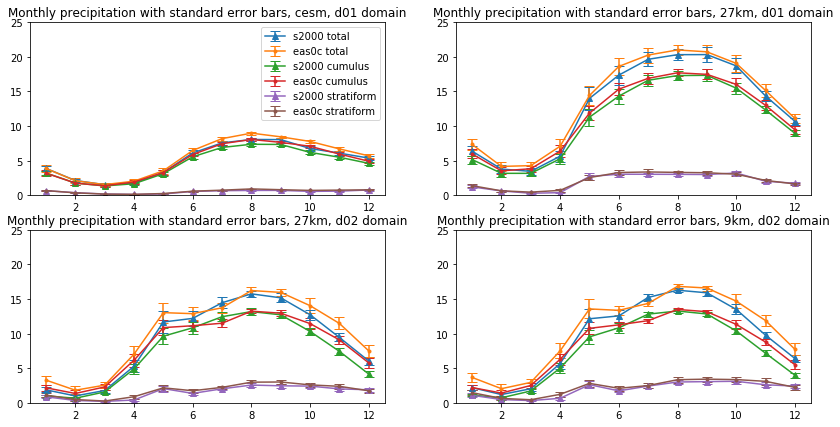

In [95]:
plt.rcParams["figure.figsize"] = 14,7
landmsk_d01=s1_d01.LANDMASK.data

t=np.arange(1,13)

plt.figure(1)
plt.subplot(2,2,1)
plt.errorbar(t,np.mean(s1_cesm_mth_agg,axis=(1,2)),s1_cesm_mth_sem, marker='^',capsize=5,label='s2000 total')
plt.errorbar(t,np.mean(s2_cesm_mth_agg,axis=(1,2)),s2_cesm_mth_sem, marker='.',capsize=5,label='eas0c total')
plt.errorbar(t,np.mean(s1_cesm_mth_agg_cu,axis=(1,2)),s1_cesm_mth_sem_cu, marker='^',capsize=5,label='s2000 cumulus')
plt.errorbar(t,np.mean(s2_cesm_mth_agg_cu,axis=(1,2)),s2_cesm_mth_sem_cu, marker='.',capsize=5,label='eas0c cumulus')
plt.errorbar(t,np.mean(s1_cesm_mth_agg_cl,axis=(1,2)),s1_cesm_mth_sem_cl, marker='^',capsize=5,label='s2000 stratiform')
plt.errorbar(t,np.mean(s2_cesm_mth_agg_cl,axis=(1,2)),s2_cesm_mth_sem_cl, marker='.',capsize=5,label='eas0c stratiform')
plt.ylim(0,25)
plt.title('Monthly precipitation with standard error bars, cesm, d01 domain')
plt.legend()

plt.subplot(2,2,2)
plt.errorbar(t,np.mean(s1_d01_mth_agg.PPT,axis=(1,2)),s1_d01_mth_sem, marker='^',capsize=5,label='s2000 total')
plt.errorbar(t,np.mean(s2_d01_mth_agg.PPT,axis=(1,2)),s2_d01_mth_sem, marker='.',capsize=5,label='eas0c total')
plt.errorbar(t,np.mean(s1_d01_mth_agg.RAINC,axis=(1,2)),s1_d01_mth_sem_cu, marker='^',capsize=5,label='s2000 cumulus')
plt.errorbar(t,np.mean(s2_d01_mth_agg.RAINC,axis=(1,2)),s2_d01_mth_sem_cu, marker='.',capsize=5,label='eas0c cumulus')
plt.errorbar(t,np.mean(s1_d01_mth_agg.RAINNC,axis=(1,2)),s1_d01_mth_sem_cl, marker='^',capsize=5,label='s2000 stratiform')
plt.errorbar(t,np.mean(s2_d01_mth_agg.RAINNC,axis=(1,2)),s2_d01_mth_sem_cl, marker='.',capsize=5,label='eas0c stratiform')
plt.ylim(0,25)
plt.title('Monthly precipitation with standard error bars, 27km, d01 domain')

plt.subplot(2,2,3)
plt.errorbar(t,np.mean(s1_d012_mth_agg.PPT,axis=(1,2)),s1_d012_mth_sem, marker='^',capsize=5,label='s2000 total')
plt.errorbar(t,np.mean(s2_d012_mth_agg.PPT,axis=(1,2)),s2_d012_mth_sem, marker='.',capsize=5,label='eas0c total')
plt.errorbar(t,np.mean(s1_d012_mth_agg.RAINC,axis=(1,2)),s1_d012_mth_sem_cu, marker='^',capsize=5,label='s2000 cumulus')
plt.errorbar(t,np.mean(s2_d012_mth_agg.RAINC,axis=(1,2)),s2_d012_mth_sem_cu, marker='.',capsize=5,label='eas0c cumulus')
plt.errorbar(t,np.mean(s1_d012_mth_agg.RAINNC,axis=(1,2)),s1_d012_mth_sem_cl, marker='^',capsize=5,label='s2000 stratiform')
plt.errorbar(t,np.mean(s2_d012_mth_agg.RAINNC,axis=(1,2)),s2_d012_mth_sem_cl, marker='.',capsize=5,label='eas0c stratiform')
plt.ylim(0,25)
plt.title('Monthly precipitation with standard error bars, 27km, d02 domain')

plt.subplot(2,2,4)
plt.errorbar(t,np.mean(s1_d02_mth_agg.PPT,axis=(1,2)),s1_d02_mth_sem, marker='^',capsize=5,label='s2000 total')
plt.errorbar(t,np.mean(s2_d02_mth_agg.PPT,axis=(1,2)),s2_d02_mth_sem, marker='.',capsize=5,label='eas0c total')
plt.errorbar(t,np.mean(s1_d02_mth_agg.RAINC,axis=(1,2)),s1_d02_mth_sem_cu, marker='^',capsize=5,label='s2000 cumulus')
plt.errorbar(t,np.mean(s2_d02_mth_agg.RAINC,axis=(1,2)),s2_d02_mth_sem_cu, marker='.',capsize=5,label='eas0c cumulus')
plt.errorbar(t,np.mean(s1_d02_mth_agg.RAINNC,axis=(1,2)),s1_d02_mth_sem_cl, marker='^',capsize=5,label='s2000 stratiform')
plt.errorbar(t,np.mean(s2_d02_mth_agg.RAINNC,axis=(1,2)),s2_d02_mth_sem_cl, marker='.',capsize=5,label='eas0c stratiform')
plt.ylim(0,25)
plt.title('Monthly precipitation with standard error bars, 9km, d02 domain')
 
plt.show()

### 2. Plot seasonal difference and means

new lim 0.0
new lim 0.0
new lim 0.011229946524064172
new lim 0.0
new lim 0.0
new lim 0.0
new lim 0.0
new lim 0.0
new lim 0.0
new lim 0.0
new lim 0.0
new lim 0.0
new lim 0.0
new lim 0.0
new lim 0.0
new lim 0.0


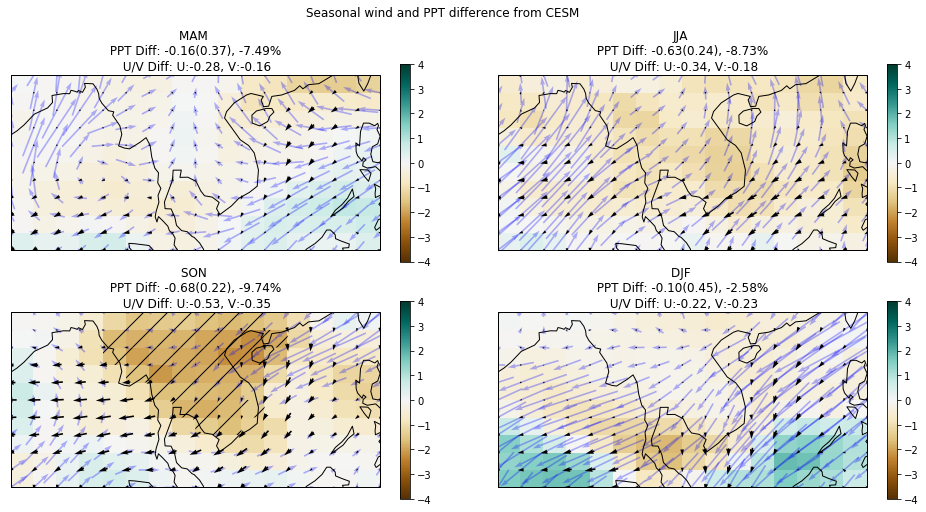

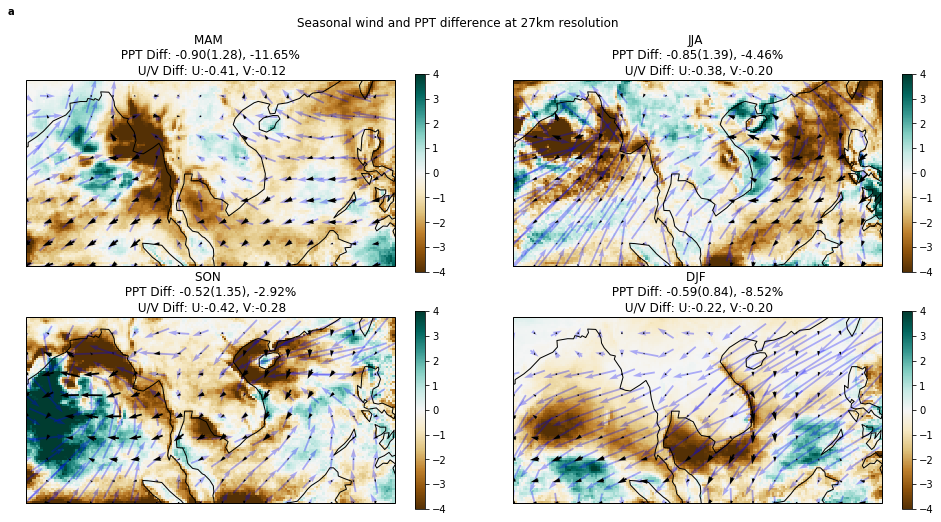

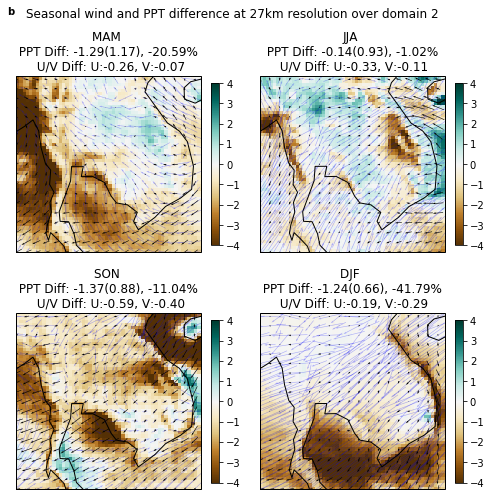

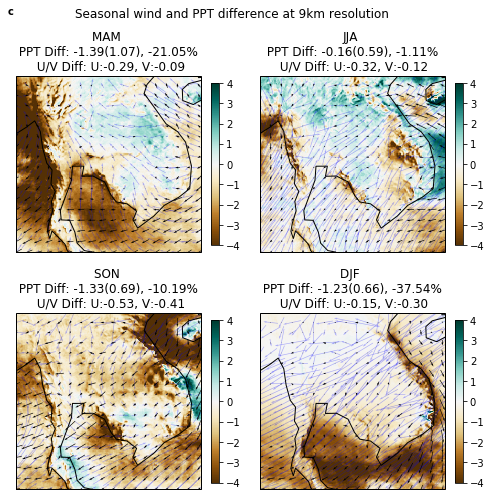

In [96]:
def seasonal_plots(s1_mth,s2_mth,ind,windy=False,cesm=False):
    s1_qtr,s1_formsk,s1_qtr_sem=agg_qtr(s1_mth.PPT)
    s2_qtr,s2_formsk,s2_qtr_sem=agg_qtr(s2_mth.PPT)
    if cesm:
        s1U10,b,a=agg_qtr(s1_mth.U10[:,-1,:,:])
        s1V10,b,a=agg_qtr(s1_mth.V10[:,-1,:,:])
        s2U10,b,a=agg_qtr(s2_mth.U10[:,-1,:,:])
        s2V10,b,a=agg_qtr(s2_mth.V10[:,-1,:,:])
    else:
        s1U10,b,a=agg_qtr(s1_mth.U10)
        s1V10,b,a=agg_qtr(s1_mth.V10)
        s2U10,b,a=agg_qtr(s2_mth.U10)
        s2V10,b,a=agg_qtr(s2_mth.V10)
    pptdiff=s1_qtr-s2_qtr
    if cesm:
        udiff=s1U10-s2U10
        vdiff=s1V10-s2V10
        ubase=s2U10
        vbase=s2V10
    elif windy:
        udiff=s1U10[:,::3,::3]-s2U10[:,::3,::3]
        vdiff=s1V10[:,::3,::3]-s2V10[:,::3,::3]
        ubase=s2U10[:,::3,::3]
        vbase=s2V10[:,::3,::3]
    else:
        udiff=s1U10[:,::10,::10]-s2U10[:,::10,::10]
        vdiff=s1V10[:,::10,::10]-s2V10[:,::10,::10]
        ubase=s2U10[:,::10,::10]
        vbase=s2V10[:,::10,::10]

    if cesm:
        slon1 = s1_mth.lon
        slat1 = s1_mth.lat       
    elif windy:
        slon1 = s1_mth.lon[0::3]
        slat1 = s1_mth.lat[0::3]
    else:
        slon1 = s1_mth.lon[0::10]
        slat1 = s1_mth.lat[0::10]
    cmap = plt.get_cmap('BrBG')
    vminn=-4
    vmaxx=4
    scale=8 # how scale affects length of vector: 1 m/s = 1 inch / scale
    basescale=16
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=matplotlib.colors.Normalize(vmin=vminn, vmax=vmaxx))
    sm._A = []
    def draw_title(tt):
        return str('{} \n PPT Diff: {:.2f}({:.2f}), {:.2f}% \n U/V Diff: U:{:.2f}, V:{:.2f}'.format(quarters[tt+1],np.nanmean(pptdiff[tt,:,:]),\
                add_sem(s1_qtr_sem[tt],s2_qtr_sem[tt]), (np.nanmean(pptdiff[tt,:,:])/np.nanmean(s1_qtr[tt,:,:])*100), \
                float(np.mean(udiff[tt,:,:])),float(np.mean(vdiff[tt,:,:])) ))
    def draw_qtr_plt(ax,tt):
        ax.pcolormesh(s1_mth.lon, s1_mth.lat,pptdiff[tt,:,:],vmin=vminn,vmax=vmaxx,cmap=cmap)
        ax.pcolor(s1_mth.lon, s1_mth.lat, new_msk(s1_formsk[:,tt,:,:],s2_formsk[:,tt,:,:]), hatch='/', alpha=0.)
        ax.quiver(slon1,slat1,ubase[tt,:,:],vbase[tt,:,:],pivot='middle',scale=scale,scale_units='inches',color='blue',alpha=0.3)
        ax.quiver(slon1,slat1,udiff[tt,:,:],vdiff[tt,:,:],pivot='middle',scale=scale,scale_units='inches')
        ax.coastlines()
        plt.colorbar(sm,ax=ax,fraction=0.04, pad=0.05)
        ax.set_title(draw_title(tt))


    ax1=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
    draw_qtr_plt(ax1,0)
    ax2=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
    draw_qtr_plt(ax2,1)
    ax3=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
    draw_qtr_plt(ax3,2)
    ax4=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
    draw_qtr_plt(ax4,3)

    ax1.text(-0.05, 1.35, ind, transform=ax1.transAxes, 
                size=10, weight='bold')

plt.rcParams["figure.figsize"] = 16,8
plt.figure(1)
seasonal_plots(s1_cesm_all,s2_cesm_all,'',cesm=True)
plt.suptitle('Seasonal wind and PPT difference from CESM')

plt.figure(2)
seasonal_plots(s1_d01_mth,s2_d01_mth,'a')
plt.suptitle('Seasonal wind and PPT difference at 27km resolution')

plt.rcParams["figure.figsize"] = 8,8
plt.figure(3)
seasonal_plots(s1_d012_mth,s2_d012_mth,'b',windy=True)
plt.suptitle('Seasonal wind and PPT difference at 27km resolution over domain 2')

plt.figure(4)
seasonal_plots(s1_d02_mth,s2_d02_mth,'c')
plt.suptitle('Seasonal wind and PPT difference at 9km resolution')

plt.show()

### 3. Plot overall diff

In [97]:
def ave_diff(thes1,thes2,var):
    s1=thes1[var]
    s2=thes2[var]
    pctDiff=(np.mean(s1)-np.mean(s2))/np.mean(s1)*100
    return np.mean(s1-s2,axis=0),pctDiff

def plt_diff(thes1,thes2,var,title,ax):
    aveDiff,pctDiff=ave_diff(thes1,thes2,var)
    ax.pcolor(thes1.lon,thes1.lat,aveDiff,cmap='BrBG',vmin=-3,vmax=3)
    # ax.contour(s1raw.lon,s1raw.lat,geo02.HGT_M[0,5:-5,5:-5],levels=[50,100,200,400,800])
    ax.coastlines()
    ax.add_feature(cfeature.RIVERS)
    cmap = plt.get_cmap('BrBG')
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=matplotlib.colors.Normalize(vmin=-3, vmax=3))
    sm._A = []
    plt.colorbar(sm,ax=ax,fraction=0.04, pad=0.05) #fraction=0.25 for d01
    ax.pcolor(thes1.lon, thes1.lat, new_msk(thes1[var],thes2[var]), hatch='/', alpha=0.)
    titleLine=title+' \n Avg Diff: '+str('{:.2f}'.format(np.nanmean(aveDiff))) \
    +'('+str('{:.2f}'.format(add_sem(sem(np.mean(thes1[var].data,axis=(1,2))),sem(np.mean(thes2[var].data,axis=(1,2))))))+')' \
    +'mm/d ='+str('{:.2f}'.format(float(pctDiff)))+'%'
    plt.title(titleLine)


new lim 0.0
new lim 0.0037433155080213902
new lim 0.0


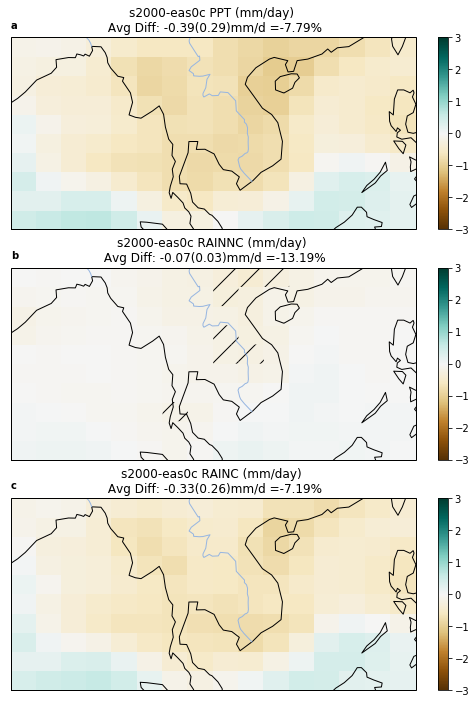

new lim 0.020442828816920028
new lim 0.0061764705882352946
new lim 0.023169200264375415


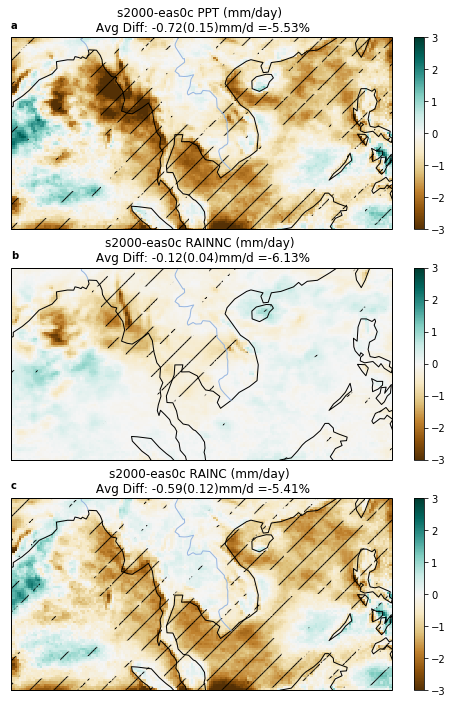

new lim 0.03031015037593985
new lim 0.018076441102756895
new lim 0.028070175438596492


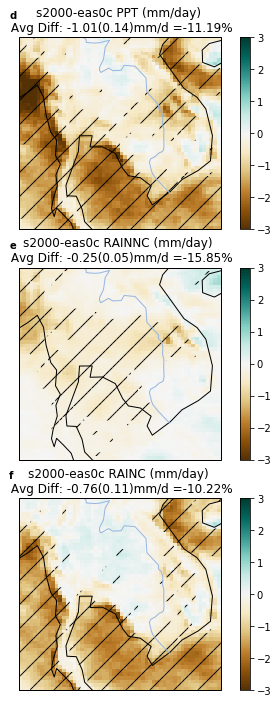

new lim 0.029552873172390345
new lim 0.013539612376742605
new lim 0.029632777966678004


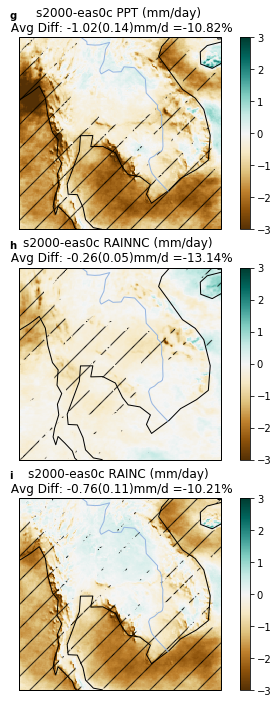

In [98]:
plt.rcParams["figure.figsize"] = 8,12#12,18#12,8,6

plt.figure(1)
ax1=plt.subplot(3,1,1,projection=ccrs.PlateCarree())
title='s2000-eas0c PPT (mm/day)'
plt_diff(s1_cesm_all,s2_cesm_all,'PPT',title,ax1)
ax1.text(0.0, 1.05, 'a', transform=ax1.transAxes, 
            size=10, weight='bold')
ax2=plt.subplot(3,1,2,projection=ccrs.PlateCarree())
title='s2000-eas0c RAINNC (mm/day)'
plt_diff(s1_cesm_all,s2_cesm_all,'RAINNC',title,ax2)
ax2.text(0, 1.05, 'b', transform=ax2.transAxes, 
            size=10, weight='bold')
ax3=plt.subplot(3,1,3,projection=ccrs.PlateCarree())
title='s2000-eas0c RAINC (mm/day)'
plt_diff(s1_cesm_all,s2_cesm_all,'RAINC',title,ax3)
ax3.text(0.0, 1.05, 'c', transform=ax3.transAxes, 
            size=10, weight='bold')
plt.show()

plt.figure(2)
ax1=plt.subplot(3,1,1,projection=ccrs.PlateCarree())
title='s2000-eas0c PPT (mm/day)'
plt_diff(s1_d01,s2_d01,'PPT',title,ax1)
ax1.text(0.0, 1.05, 'a', transform=ax1.transAxes, 
            size=10, weight='bold')
ax2=plt.subplot(3,1,2,projection=ccrs.PlateCarree())
title='s2000-eas0c RAINNC (mm/day)'
plt_diff(s1_d01,s2_d01,'RAINNC',title,ax2)
ax2.text(0, 1.05, 'b', transform=ax2.transAxes, 
            size=10, weight='bold')
ax3=plt.subplot(3,1,3,projection=ccrs.PlateCarree())
title='s2000-eas0c RAINC (mm/day)'
plt_diff(s1_d01,s2_d01,'RAINC',title,ax3)
ax3.text(0.0, 1.05, 'c', transform=ax3.transAxes, 
            size=10, weight='bold')
plt.show()

plt.rcParams["figure.figsize"] = 7,12
plt.figure(3)
ax1=plt.subplot(3,1,1,projection=ccrs.PlateCarree())
title='s2000-eas0c PPT (mm/day)'
plt_diff(s1_d012,s2_d012,'PPT',title,ax1)
ax1.text(-0.05, 1.1, 'd', transform=ax1.transAxes, 
            size=10, weight='bold')
ax2=plt.subplot(3,1,2,projection=ccrs.PlateCarree())
title='s2000-eas0c RAINNC (mm/day)'
plt_diff(s1_d012,s2_d012,'RAINNC',title,ax2)
ax2.text(-0.05, 1.1, 'e', transform=ax2.transAxes, 
            size=10, weight='bold')
ax3=plt.subplot(3,1,3,projection=ccrs.PlateCarree())
title='s2000-eas0c RAINC (mm/day)'
plt_diff(s1_d012,s2_d012,'RAINC',title,ax3)
ax3.text(-0.05, 1.1, 'f', transform=ax3.transAxes, 
            size=10, weight='bold')
plt.show()

plt.figure(4)
ax1=plt.subplot(3,1,1,projection=ccrs.PlateCarree())
title='s2000-eas0c PPT (mm/day)'
plt_diff(s1_d02,s2_d02,'PPT',title,ax1)
ax1.text(-0.05, 1.1, 'g', transform=ax1.transAxes, 
            size=10, weight='bold')
ax2=plt.subplot(3,1,2,projection=ccrs.PlateCarree())
title='s2000-eas0c RAINNC (mm/day)'
plt_diff(s1_d02,s2_d02,'RAINNC',title,ax2)
ax2.text(-0.05, 1.1, 'h', transform=ax2.transAxes, 
            size=10, weight='bold')
ax3=plt.subplot(3,1,3,projection=ccrs.PlateCarree())
title='s2000-eas0c RAINC (mm/day)'
plt_diff(s1_d02,s2_d02,'RAINC',title,ax3)
ax3.text(-0.05, 1.1, 'i', transform=ax3.transAxes, 
            size=10, weight='bold')

plt.show()

### 4. Plot domain mean with errorbars

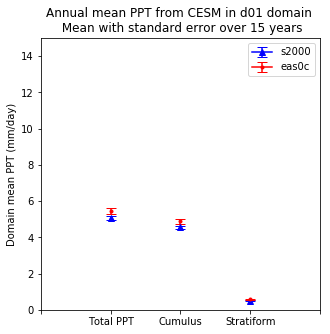

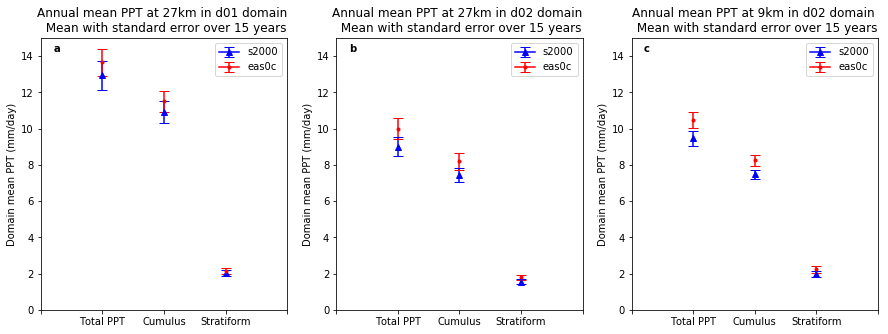

In [99]:
plt.rcParams["figure.figsize"] = 5,5

plt.figure(1)
plt.errorbar(2,np.mean(s1_cesm_all.resample('AS',dim='time',how='mean').PPT),sem(np.mean(s1_cesm_all.resample('AS',dim='time',how='mean').PPT,axis=(1,2))), marker='^',capsize=5,color='b',label='s2000')
plt.errorbar(2,np.mean(s2_cesm_all.resample('AS',dim='time',how='mean').PPT),sem(np.mean(s2_cesm_all.resample('AS',dim='time',how='mean').PPT,axis=(1,2))), marker='.',capsize=5,color='r',label='eas0c')
plt.errorbar(3,np.mean(s1_cesm_all.resample('AS',dim='time',how='mean').RAINC),sem(np.mean(s1_cesm_all.resample('AS',dim='time',how='mean').RAINC,axis=(1,2))), marker='^',capsize=5,color='b',label='_nolegend_')
plt.errorbar(3,np.mean(s2_cesm_all.resample('AS',dim='time',how='mean').RAINC),sem(np.mean(s2_cesm_all.resample('AS',dim='time',how='mean').RAINC,axis=(1,2))), marker='.',capsize=5,color='r',label='_nolegend_')
plt.errorbar(4,np.mean(s1_cesm_all.resample('AS',dim='time',how='mean').RAINNC),sem(np.mean(s1_cesm_all.resample('AS',dim='time',how='mean').RAINNC,axis=(1,2))), marker='^',capsize=5,color='b',label='_nolegend_')
plt.errorbar(4,np.mean(s2_cesm_all.resample('AS',dim='time',how='mean').RAINNC),sem(np.mean(s2_cesm_all.resample('AS',dim='time',how='mean').RAINNC,axis=(1,2))), marker='.',capsize=5,color='r',label='_nolegend_')
plt.ylim(0,15)
my_xticks=['','Total PPT','Cumulus','Stratiform','']
plt.xticks([1,2,3,4,5],my_xticks)
plt.ylabel('Domain mean PPT (mm/day)')
plt.title('Annual mean PPT from CESM in d01 domain \n Mean with standard error over 15 years')
plt.legend()

plt.rcParams["figure.figsize"] = 15,5
plt.figure(2)
ax=plt.subplot(1,3,1)
plt.errorbar(2,np.mean(s1_d01.resample('AS',dim='time',how='mean').PPT),sem(np.mean(s1_d01.resample('AS',dim='time',how='mean').PPT,axis=(1,2))), marker='^',capsize=5,color='b',label='s2000')
plt.errorbar(2,np.mean(s2_d01.resample('AS',dim='time',how='mean').PPT),sem(np.mean(s2_d01.resample('AS',dim='time',how='mean').PPT,axis=(1,2))), marker='.',capsize=5,color='r',label='eas0c')
plt.errorbar(3,np.mean(s1_d01.resample('AS',dim='time',how='mean').RAINC),sem(np.mean(s1_d01.resample('AS',dim='time',how='mean').RAINC,axis=(1,2))), marker='^',capsize=5,color='b',label='_nolegend_')
plt.errorbar(3,np.mean(s2_d01.resample('AS',dim='time',how='mean').RAINC),sem(np.mean(s2_d01.resample('AS',dim='time',how='mean').RAINC,axis=(1,2))), marker='.',capsize=5,color='r',label='_nolegend_')
plt.errorbar(4,np.mean(s1_d01.resample('AS',dim='time',how='mean').RAINNC),sem(np.mean(s1_d01.resample('AS',dim='time',how='mean').RAINNC,axis=(1,2))), marker='^',capsize=5,color='b',label='_nolegend_')
plt.errorbar(4,np.mean(s2_d01.resample('AS',dim='time',how='mean').RAINNC),sem(np.mean(s2_d01.resample('AS',dim='time',how='mean').RAINNC,axis=(1,2))), marker='.',capsize=5,color='r',label='_nolegend_')
plt.ylim(0,15)
my_xticks=['','Total PPT','Cumulus','Stratiform','']
plt.xticks([1,2,3,4,5],my_xticks)
plt.ylabel('Domain mean PPT (mm/day)')
plt.title('Annual mean PPT at 27km in d01 domain \n Mean with standard error over 15 years')
plt.legend()
ax.text(0.05, 0.95, 'a', transform=ax.transAxes, 
                size=10, weight='bold')

ax=plt.subplot(1,3,2)
plt.errorbar(2,np.mean(s1_d012.resample('AS',dim='time',how='mean').PPT),sem(np.mean(s1_d012.resample('AS',dim='time',how='mean').PPT,axis=(1,2))), marker='^',capsize=5,color='b',label='s2000')
plt.errorbar(2,np.mean(s2_d012.resample('AS',dim='time',how='mean').PPT),sem(np.mean(s2_d012.resample('AS',dim='time',how='mean').PPT,axis=(1,2))), marker='.',capsize=5,color='r',label='eas0c')
plt.errorbar(3,np.mean(s1_d012.resample('AS',dim='time',how='mean').RAINC),sem(np.mean(s1_d012.resample('AS',dim='time',how='mean').RAINC,axis=(1,2))), marker='^',capsize=5,color='b',label='_nolegend_')
plt.errorbar(3,np.mean(s2_d012.resample('AS',dim='time',how='mean').RAINC),sem(np.mean(s2_d012.resample('AS',dim='time',how='mean').RAINC,axis=(1,2))), marker='.',capsize=5,color='r',label='_nolegend_')
plt.errorbar(4,np.mean(s1_d012.resample('AS',dim='time',how='mean').RAINNC),sem(np.mean(s1_d012.resample('AS',dim='time',how='mean').RAINNC,axis=(1,2))), marker='^',capsize=5,color='b',label='_nolegend_')
plt.errorbar(4,np.mean(s2_d012.resample('AS',dim='time',how='mean').RAINNC),sem(np.mean(s2_d012.resample('AS',dim='time',how='mean').RAINNC,axis=(1,2))), marker='.',capsize=5,color='r',label='_nolegend_')
plt.ylim(0,15)
my_xticks=['','Total PPT','Cumulus','Stratiform','']
plt.xticks([1,2,3,4,5],my_xticks)
plt.ylabel('Domain mean PPT (mm/day)')
plt.title('Annual mean PPT at 27km in d02 domain \n Mean with standard error over 15 years')
plt.legend()
ax.text(0.05, 0.95, 'b', transform=ax.transAxes, 
                size=10, weight='bold')

ax=plt.subplot(1,3,3)
plt.errorbar(2,np.mean(s1_d02.resample('AS',dim='time',how='mean').PPT),sem(np.mean(s1_d02.resample('AS',dim='time',how='mean').PPT,axis=(1,2))), marker='^',capsize=5,color='b',label='s2000')
plt.errorbar(2,np.mean(s2_d02.resample('AS',dim='time',how='mean').PPT),sem(np.mean(s2_d02.resample('AS',dim='time',how='mean').PPT,axis=(1,2))), marker='.',capsize=5,color='r',label='eas0c')
plt.errorbar(3,np.mean(s1_d02.resample('AS',dim='time',how='mean').RAINC),sem(np.mean(s1_d02.resample('AS',dim='time',how='mean').RAINC,axis=(1,2))), marker='^',capsize=5,color='b',label='_nolegend_')
plt.errorbar(3,np.mean(s2_d02.resample('AS',dim='time',how='mean').RAINC),sem(np.mean(s2_d02.resample('AS',dim='time',how='mean').RAINC,axis=(1,2))), marker='.',capsize=5,color='r',label='_nolegend_')
plt.errorbar(4,np.mean(s1_d02.resample('AS',dim='time',how='mean').RAINNC),sem(np.mean(s1_d02.resample('AS',dim='time',how='mean').RAINNC,axis=(1,2))), marker='^',capsize=5,color='b',label='_nolegend_')
plt.errorbar(4,np.mean(s2_d02.resample('AS',dim='time',how='mean').RAINNC),sem(np.mean(s2_d02.resample('AS',dim='time',how='mean').RAINNC,axis=(1,2))), marker='.',capsize=5,color='r',label='_nolegend_')
plt.ylim(0,15)
my_xticks=['','Total PPT','Cumulus','Stratiform','']
plt.xticks([1,2,3,4,5],my_xticks)
plt.ylabel('Domain mean PPT (mm/day)')
plt.title('Annual mean PPT at 9km in d02 domain \n Mean with standard error over 15 years')
plt.legend()
ax.text(0.05, 0.95, 'c', transform=ax.transAxes, 
                size=10, weight='bold')

plt.show()

### 5. Plot seasonal mean with error bars

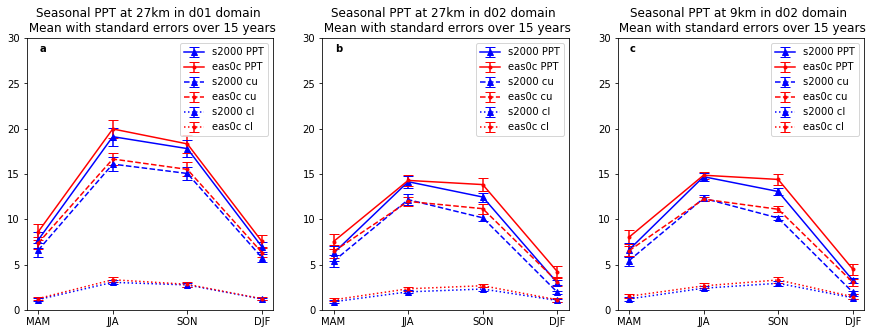

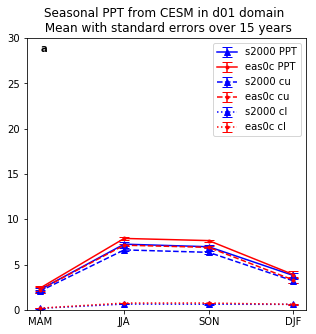

In [100]:
def plt_qtr(s1,s2):
    t=np.arange(1,5)
    my_xticks=['MAM','JJA','SON','DJF']
    plt.xticks([1,2,3,4],my_xticks)
    plt.ylim(0,30)
    s1_qtr,s1_formsk,s1_qtr_sem=agg_qtr(s1.PPT)
    s2_qtr,s2_formsk,s2_qtr_sem=agg_qtr(s2.PPT)
    s1_qtr_cu,s1_formsk,s1_qtr_sem_cu=agg_qtr(s1.RAINC)
    s2_qtr_cu,s2_formsk,s2_qtr_sem_cu=agg_qtr(s2.RAINC)
    s1_qtr_cl,s1_formsk,s1_qtr_sem_cl=agg_qtr(s1.RAINNC)
    s2_qtr_cl,s2_formsk,s2_qtr_sem_cl=agg_qtr(s2.RAINNC)
    plt.errorbar(t,np.mean(s1_qtr,axis=(1,2)),s1_qtr_sem, marker='^',capsize=5,color='b',label='s2000 PPT')
    plt.errorbar(t,np.mean(s2_qtr,axis=(1,2)),s2_qtr_sem, marker='.',capsize=5,color='r',label='eas0c PPT')
    plt.errorbar(t,np.mean(s1_qtr_cu,axis=(1,2)),s1_qtr_sem_cu, marker='^',capsize=5,color='b',ls='--',label='s2000 cu')
    plt.errorbar(t,np.mean(s2_qtr_cu,axis=(1,2)),s2_qtr_sem_cu, marker='.',capsize=5,color='r',ls='--',label='eas0c cu')
    plt.errorbar(t,np.mean(s1_qtr_cl,axis=(1,2)),s1_qtr_sem_cl, marker='^',capsize=5,color='b',ls=':',label='s2000 cl')
    plt.errorbar(t,np.mean(s2_qtr_cl,axis=(1,2)),s2_qtr_sem_cl, marker='.',capsize=5,color='r',ls=':',label='eas0c cl')
    
plt.rcParams["figure.figsize"] = 15,5

plt.figure(1)
ax=plt.subplot(1,3,1)
plt_qtr(s1_d01_mth,s2_d01_mth)
plt.title('Seasonal PPT at 27km in d01 domain \n Mean with standard errors over 15 years')
plt.legend()
ax.text(0.05, 0.95, 'a', transform=ax.transAxes, 
                size=10, weight='bold')

ax=plt.subplot(1,3,2)
plt_qtr(s1_d012_mth,s2_d012_mth)
plt.title('Seasonal PPT at 27km in d02 domain \n Mean with standard errors over 15 years')
plt.legend()
ax.text(0.05, 0.95, 'b', transform=ax.transAxes, 
                size=10, weight='bold')

ax=plt.subplot(1,3,3)
plt_qtr(s1_d02_mth,s2_d02_mth)
plt.title('Seasonal PPT at 9km in d02 domain \n Mean with standard errors over 15 years')
plt.legend()
ax.text(0.05, 0.95, 'c', transform=ax.transAxes, 
                size=10, weight='bold')

plt.rcParams["figure.figsize"] = 5,5
plt.figure(2)
ax=plt.subplot()
plt_qtr(s1_cesm_all,s2_cesm_all)
plt.title('Seasonal PPT from CESM in d01 domain \n Mean with standard errors over 15 years')
plt.legend()
ax.text(0.05, 0.95, 'a', transform=ax.transAxes, 
                size=10, weight='bold')

# plt.figure(4)
# plt.errorbar(t,s1_qtrr_d02_cl,s1_qtr_d02_cl_sd, marker='^',color='b',label='s2000 stratiform')
# plt.errorbar(t,s2_qtrr_d02_cl,s2_qtr_d02_cl_sd, marker='.',color='r',label='eas0c stratiform')
# plt.ylim(0,4)
# plt.title('Seasonal stratiform precipitation with standard error bars, 9km')
# plt.legend()

plt.show()

### 5. Plot zonal means 

(11,)
(12, 11)
(11,)
(12, 89)
(11,)
(11,)
(12, 89)
(11,)
(11,)
(12, 89)


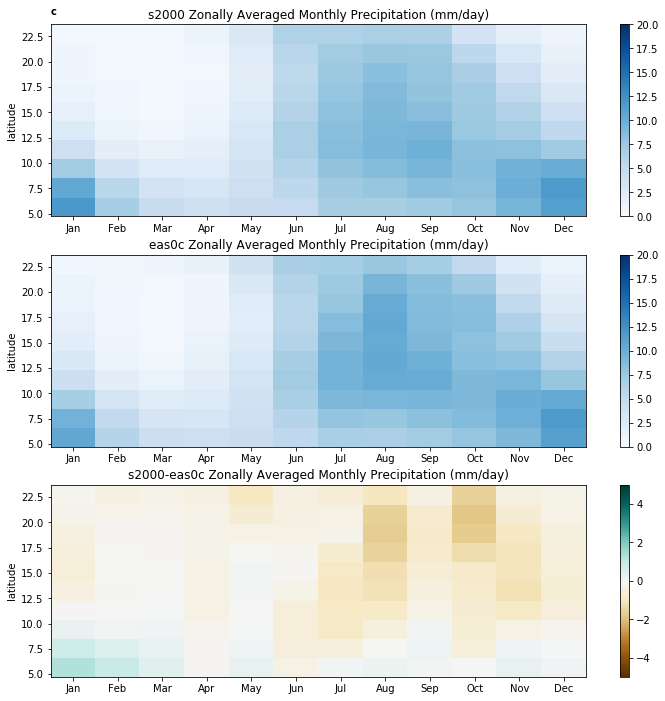

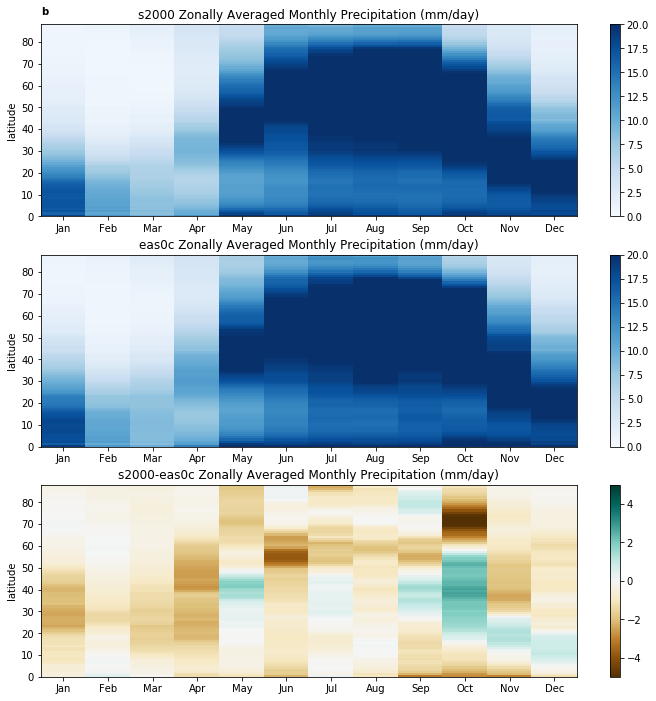

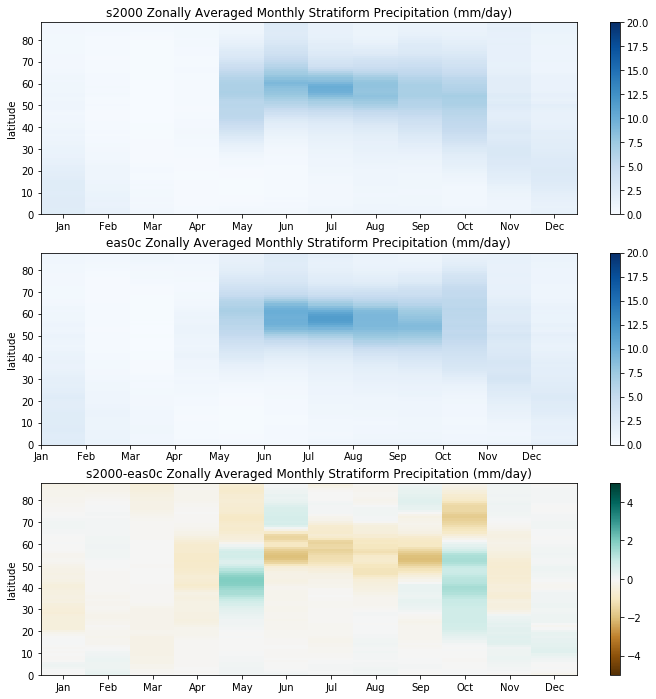

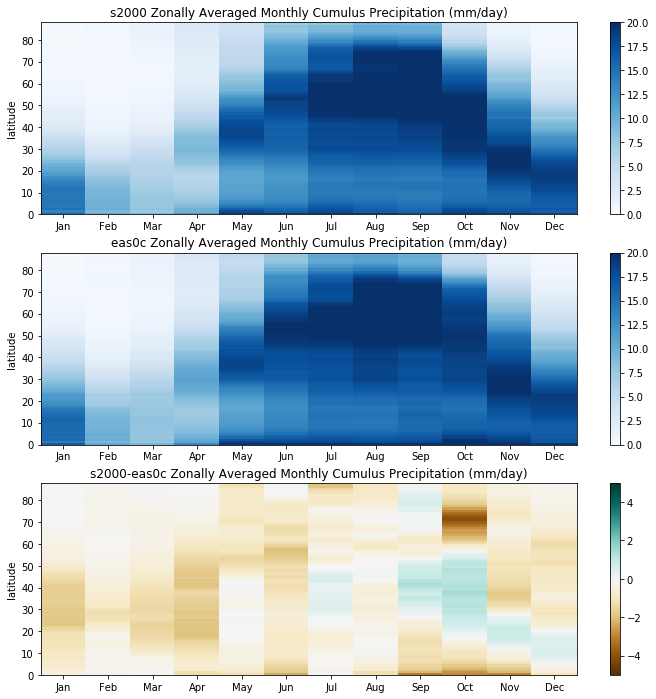

In [105]:
import matplotlib.ticker as ticker
plt.rcParams["figure.figsize"] = 12,12
my_xticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
x_pos=[1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5]


lats_mth=np.mean(s1_cesm_mth_agg,axis=2)
plt.figure(1)
plt.subplot(3,1,1)
plt.pcolormesh(np.arange(1,14),s1_cesm.lat,lats_mth.T,vmin=0,vmax=20,cmap='Blues')
plt.ylabel('latitude')
plt.title('s2000 Zonally Averaged Monthly Precipitation (mm/day)')
plt.xticks(x_pos,my_xticks)
plt.colorbar()
ax=plt.gca()
ax.text(0.0, 1.05, 'c', transform=ax.transAxes, 
                size=10, weight='bold')
lats_mth=np.mean(s2_cesm_mth_agg,axis=2)
print(np.shape(lats))
plt.subplot(3,1,2)
plt.pcolormesh(np.arange(1,14),s1_cesm.lat,lats_mth.T,vmin=0,vmax=20,cmap='Blues')
plt.ylabel('latitude')
plt.title('eas0c Zonally Averaged Monthly Precipitation (mm/day)')
plt.xticks(x_pos,my_xticks)
# plt.xticks(time_val2,my_xticks)
plt.colorbar()
lats_mth=np.mean(s1_cesm_mth_agg,axis=2)-np.mean(s2_cesm_mth_agg,axis=2)
print(np.shape(lats_mth))
plt.subplot(3,1,3)
plt.pcolormesh(np.arange(1,14),s1_cesm.lat,lats_mth.T,vmin=-5,vmax=5,cmap='BrBG')
plt.ylabel('latitude')
plt.title('s2000-eas0c Zonally Averaged Monthly Precipitation (mm/day)')
plt.xticks(x_pos,my_xticks)
# plt.xticks(time_val2,my_xticks)
plt.colorbar()

lats_mth=np.mean(s1_d01_mth_agg.PPT,axis=2)
plt.figure(2)
plt.subplot(3,1,1)
plt.pcolormesh(np.arange(1,14),s1_d01_mth_agg.lat,lats_mth.T,vmin=0,vmax=20,cmap='Blues')
plt.ylabel('latitude')
plt.title('s2000 Zonally Averaged Monthly Precipitation (mm/day)')
plt.xticks(x_pos,my_xticks)
# plt.xticks(time_val2,my_xticks)
plt.colorbar()
ax=plt.gca()
ax.text(0.0, 1.05, 'b', transform=ax.transAxes, 
                size=10, weight='bold')
lats_mth=np.mean(s2_d01_mth_agg.PPT,axis=2)
print(np.shape(lats))
plt.subplot(3,1,2)
plt.pcolormesh(np.arange(1,14),s1_d01_mth_agg.lat,lats_mth.T,vmin=0,vmax=20,cmap='Blues')
plt.ylabel('latitude')
plt.title('eas0c Zonally Averaged Monthly Precipitation (mm/day)')
plt.xticks(x_pos,my_xticks)
# plt.xticks(time_val2,my_xticks)
plt.colorbar()
lats_mth=np.mean(s1_d01_mth_agg.PPT,axis=2)-np.mean(s2_d01_mth_agg.PPT,axis=2)
print(np.shape(lats_mth))
plt.subplot(3,1,3)
plt.pcolormesh(np.arange(1,14),s1_d01_mth_agg.lat,lats_mth.T,vmin=-5,vmax=5,cmap='BrBG')
plt.ylabel('latitude')
plt.title('s2000-eas0c Zonally Averaged Monthly Precipitation (mm/day)')
plt.xticks(x_pos,my_xticks)
# plt.xticks(time_val2,my_xticks)
plt.colorbar()


lats_mth=np.mean(s1_d01_mth_agg.RAINNC,axis=2)
print(np.shape(lats))
plt.figure(3)
plt.subplot(3,1,1)
plt.pcolormesh(np.arange(1,14),s1_d01_mth_agg.lat,lats_mth.T,vmin=0,vmax=20,cmap='Blues')
plt.ylabel('latitude')
plt.title('s2000 Zonally Averaged Monthly Stratiform Precipitation (mm/day)')
plt.xticks(x_pos,my_xticks)
# plt.xticks(time_val2,my_xticks)
plt.colorbar()
lats_mth=np.mean(s2_d01_mth_agg.RAINNC,axis=2)
print(np.shape(lats))
plt.subplot(3,1,2)
plt.pcolormesh(np.arange(1,14),s1_d01_mth_agg.lat,lats_mth.T,vmin=0,vmax=20,cmap='Blues')
plt.ylabel('latitude')
plt.title('eas0c Zonally Averaged Monthly Stratiform Precipitation (mm/day)')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],my_xticks)
# plt.xticks(time_val2,my_xticks)
plt.colorbar()
lats_mth=np.mean(s1_d01_mth_agg.RAINNC,axis=2)-np.mean(s2_d01_mth_agg.RAINNC,axis=2)
print(np.shape(lats_mth))
plt.subplot(3,1,3)
plt.pcolormesh(np.arange(1,14),s1_d01_mth_agg.lat,lats_mth.T,vmin=-5,vmax=5,cmap='BrBG')
plt.ylabel('latitude')
plt.title('s2000-eas0c Zonally Averaged Monthly Stratiform Precipitation (mm/day)')
plt.xticks(x_pos,my_xticks)
# plt.xticks(time_val2,my_xticks)
plt.colorbar()

lats_mth=np.mean(s1_d01_mth_agg.RAINC,axis=2)
print(np.shape(lats))
plt.figure(4)
plt.subplot(3,1,1)
plt.pcolormesh(np.arange(1,14),s1_d01_mth_agg.lat,lats_mth.T,vmin=0,vmax=20,cmap='Blues')
plt.ylabel('latitude')
plt.title('s2000 Zonally Averaged Monthly Cumulus Precipitation (mm/day)')
plt.xticks(x_pos,my_xticks)
# plt.xticks(time_val2,my_xticks)
plt.colorbar()
lats_mth=np.mean(s2_d01_mth_agg.RAINC,axis=2)
print(np.shape(lats))
plt.subplot(3,1,2)
plt.pcolormesh(np.arange(1,14),s1_d01_mth_agg.lat,lats_mth.T,vmin=0,vmax=20,cmap='Blues')
plt.ylabel('latitude')
plt.title('eas0c Zonally Averaged Monthly Cumulus Precipitation (mm/day)')
plt.xticks(x_pos,my_xticks)
# plt.xticks(time_val2,my_xticks)
plt.colorbar()
lats_mth=np.mean(s1_d01_mth_agg.RAINC,axis=2)-np.mean(s2_d01_mth_agg.RAINC,axis=2)
print(np.shape(lats_mth))
plt.subplot(3,1,3)
plt.pcolormesh(np.arange(1,14),s1_d01_mth_agg.lat,lats_mth.T,vmin=-5,vmax=5,cmap='BrBG')
plt.ylabel('latitude')
plt.title('s2000-eas0c Zonally Averaged Monthly Cumulus Precipitation (mm/day)')
plt.xticks(x_pos,my_xticks)
# plt.xticks(time_val2,my_xticks)
plt.colorbar()

plt.show()

### 6. Plot PDF

In [133]:
plt.rcParams["figure.figsize"] = 10,6

def plot_pdf(x,label,ax,clr='k'):
    '''
    plots the PDf of a 1d array of data.
    Might have to mess around with x.data
    if there are errors.
    '''
    num_bins = 100
#     the histogram of the data
#     n, bins, patches = ax.hist(x, num_bins)
#     add a 'best fit' line
    kde=scipy.stats.gaussian_kde(x)
    t_range = np.linspace(np.min(x),np.max(x),num_bins)
    ax.plot(t_range,kde(t_range),clr,label=label)
    ax.legend()

#make landmask and seamask for CESM
landmask_cesm=cesmlandfrac.LANDFRAC[0,:,:].data > 0.5
seamask_cesm=cesmlandfrac.LANDFRAC[0,:,:].data <= 0.5
#make landmask and seamask for d01
# for some reason the index 0 and 2 of the timestep is messed up.
# I may have edited it by accident.
landmask_d01=s1_d01.LANDMASK[1,:,:].data
landmask_d01[landmask_d01==0]=np.nan
seamask_d01=(-1*(np.nan_to_num(s1_d01.LANDMASK[4,:,:].data)-1))
seamask_d01[seamask_d01==0]=np.nan
#make landmask and seamask for d012
landmask_d012=s1_d012.LANDMASK[1,:,:].data
landmask_d012[landmask_d012==0]=np.nan
seamask_d012=(-1*(np.nan_to_num(s1_d012.LANDMASK[3,:,:].data)-1))
seamask_d012[seamask_d012==0]=np.nan
#make landmask and seamask for d02
landmask_d02=s1_d02.LANDMASK[1,:,:].data
landmask_d02[landmask_d02==0]=np.nan
seamask_d02=(-1*(np.nan_to_num(s1_d02.LANDMASK[3,:,:].data)-1))
seamask_d02[seamask_d02==0]=np.nan

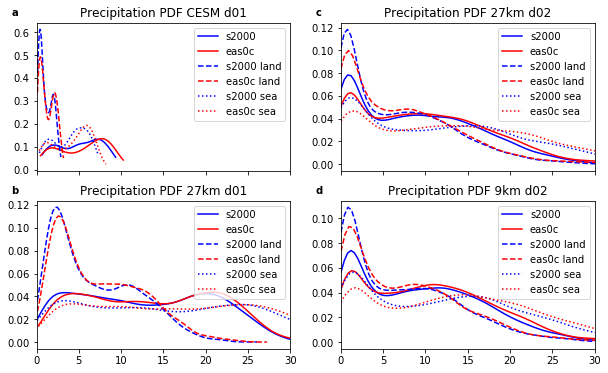

In [139]:
plt.figure(1)
fig, ax = plt.subplots(2,2,sharex=True)#,sharey=True)
ax[0,0].set_title('Precipitation PDF CESM d01')
x=np.mean(s1_cesm_all.PPT,axis=(1,2))
# x=s1_cesm_all.PPT.data.flatten()
plot_pdf(x,'s2000',ax[0,0],'b')
x2=np.mean(s2_cesm_all.PPT,axis=(1,2))
# x2=s2_cesm_all.PPT.data.flatten()
plot_pdf(x2,'eas0c',ax[0,0],'r')
x3=np.nanmean(s1_cesm_all.PPT*landmask_cesm,axis=(1,2))
# x3=(s1_cesm_all.PPT.data*landmask_cesm).flatten()
# x3= x3[~np.isnan(x3)]
plot_pdf(x3,'s2000 land',ax[0,0],'b--')
x4=np.nanmean(s2_cesm_all.PPT*landmask_cesm,axis=(1,2))
# x4=(s2_cesm_all.PPT.data*landmask_cesm).flatten()
# x4= x4[~np.isnan(x4)]
plot_pdf(x4,'eas0c land',ax[0,0],'r--')
x5=np.nanmean(s1_cesm_all.PPT*seamask_cesm,axis=(1,2))
# x5=(s1_cesm_all.PPT.data*seamask_cesm).flatten()
# x5= x5[~np.isnan(x5)]
plot_pdf(x5,'s2000 sea',ax[0,0],'b:')
x6=np.nanmean(s2_cesm_all.PPT*seamask_cesm,axis=(1,2))
# x6=(s2_cesm_all.PPT.data*seamask_cesm).flatten()
# x6= x6[~np.isnan(x6)]
plot_pdf(x6,'eas0c sea',ax[0,0],'r:')
plt.xlim( (0, 30) )
ax[0,0].text(-0.1, 1.05, 'a', transform=ax[0,0].transAxes, 
            size=10, weight='bold')


ax[1,0].set_title('Precipitation PDF 27km d01')
x=np.mean(s1_d01.PPT,axis=(1,2))
# x=s1_d01_mth.PPT.data.flatten()
plot_pdf(x,'s2000',ax[1,0],'b')
x2=np.mean(s2_d01.PPT,axis=(1,2))
# x2=s2_d02_mth.PPT.data.flatten()
plot_pdf(x2,'eas0c',ax[1,0],'r')
x3=np.mean(s1_d01.PPT*landmask_d01,axis=(1,2))
# x3=(s1_d01_mth.PPT.data*landmask_d01).flatten()
# x3= x3[~np.isnan(x3)]
plot_pdf(x3,'s2000 land',ax[1,0],'b--')
x4=np.mean(s2_d01.PPT*landmask_d01,axis=(1,2))
# x4=(s2_d01_mth.PPT.data*landmask_d01).flatten()
# x4= x4[~np.isnan(x4)]
plot_pdf(x4,'eas0c land',ax[1,0],'r--')
x5=np.mean(s1_d01.PPT*seamask_d01,axis=(1,2))
# x5=(s1_d01_mth.PPT.data*seamask_d01).flatten()
# x5= x5[~np.isnan(x5)]
plot_pdf(x5,'s2000 sea',ax[1,0],'b:')
x6=np.mean(s2_d01.PPT*seamask_d01,axis=(1,2))
# x6=(s2_d01_mth.PPT.data*seamask_d01).flatten()
# x6= x6[~np.isnan(x6)]
plot_pdf(x6,'eas0c sea',ax[1,0],'r:')
ax[1,0].text(-0.1, 1.05, 'b', transform=ax[1,0].transAxes, 
            size=10, weight='bold')


#d02
latmin=6.74
latmax=20.40
lonmin=95.74
lonmax=110.08


ax[0,1].set_title('Precipitation PDF 27km d02')
x=np.mean(s1_d012.PPT,axis=(1,2))
# x=s1_d012_mth.PPT.data.flatten()
plot_pdf(x,'s2000',ax[0,1],'b')
x2=np.mean(s2_d012.PPT,axis=(1,2))
# x2=s2_d012_mth.PPT.data.flatten()
plot_pdf(x2,'eas0c',ax[0,1],'r')
x3=np.mean(s1_d012.PPT*landmask_d012,axis=(1,2))
# x3=(s1_d012_mth.PPT.data*landmask_d012).flatten()
# x3= x3[~np.isnan(x3)]
plot_pdf(x3,'s2000 land',ax[0,1],'b--')
x4=np.mean(s2_d012.PPT*landmask_d012,axis=(1,2))
# x4=(s2_d012_mth.PPT.data*landmask_d012).flatten()
# x4= x4[~np.isnan(x4)]
plot_pdf(x4,'eas0c land',ax[0,1],'r--')
x5=np.mean(s1_d012.PPT*seamask_d012,axis=(1,2))
# x5=(s1_d012_mth.PPT.data*seamask_d012).flatten()
# x5= x5[~np.isnan(x5)]
plot_pdf(x5,'s2000 sea',ax[0,1],'b:')
x6=np.mean(s2_d012.PPT*seamask_d012,axis=(1,2))
# x6=(s2_d012_mth.PPT.data*seamask_d012).flatten()
# x6= x6[~np.isnan(x6)]
plot_pdf(x6,'eas0c sea',ax[0,1],'r:')
ax[0,1].text(-0.1, 1.05, 'c', transform=ax[0,1].transAxes, 
            size=10, weight='bold')

ax[1,1].set_title('Precipitation PDF 9km d02')
x=np.mean(s1_d02.PPT,axis=(1,2))
# x=s1_d02_mth.PPT.data.flatten()
plot_pdf(x,'s2000',ax[1,1],'b')
x2=np.mean(s2_d02.PPT,axis=(1,2))
# x2=s2_d02_mth.PPT.data.flatten()
plot_pdf(x2,'eas0c',ax[1,1],'r')
x3=np.mean(s1_d02.PPT*landmask_d02,axis=(1,2))
# x3=(s1_d02_mth.PPT.data*landmask_d02).flatten()
# x3= x3[~np.isnan(x3)]
plot_pdf(x3,'s2000 land',ax[1,1],'b--')
x4=np.mean(s2_d02.PPT*landmask_d02,axis=(1,2))
# x4=(s2_d02_mth.PPT.data*landmask_d02).flatten()
# x4= x4[~np.isnan(x4)]
plot_pdf(x4,'eas0c land',ax[1,1],'r--')
x5=np.mean(s1_d02.PPT*seamask_d02,axis=(1,2))
# x5=(s1_d02_mth.PPT.data*seamask_d02).flatten()
# x5= x5[~np.isnan(x5)]
plot_pdf(x5,'s2000 sea',ax[1,1],'b:')
x6=np.mean(s2_d02.PPT*seamask_d02,axis=(1,2))
# x6=(s2_d02_mth.PPT.data*seamask_d02).flatten()
# x6= x6[~np.isnan(x6)]
plot_pdf(x6,'eas0c sea',ax[1,1],'r:')
ax[1,1].text(-0.1, 1.05, 'd', transform=ax[1,1].transAxes, 
            size=10, weight='bold')

plt.show()

Day by day of each gridpoint is computationally ridiculous. I ran the script before lunch, and now it is 5pm, and it is still running. Either I do daily domain means, or monthly individual gridpoints.  
Thinking further, to have an effective comparison with CESM, it makes sense to get the monthly means, and do a gridpoint by gridpoint comparison.

### Quarterly PDF

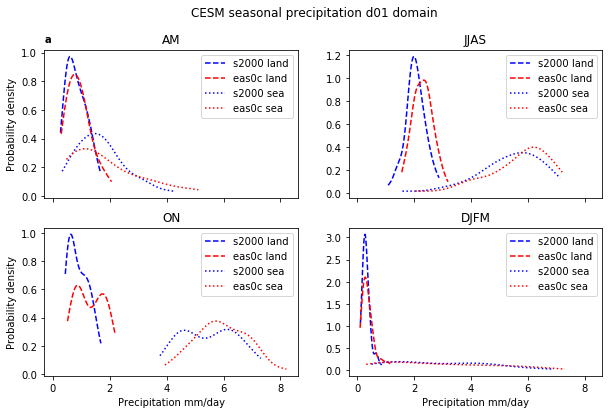

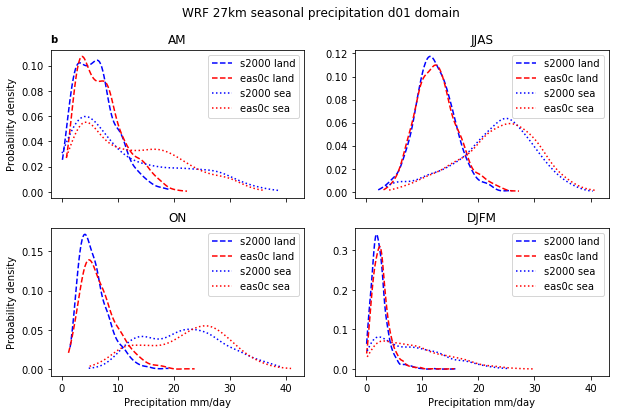

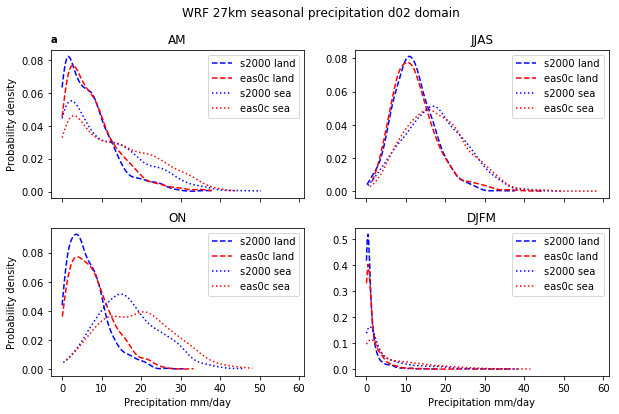

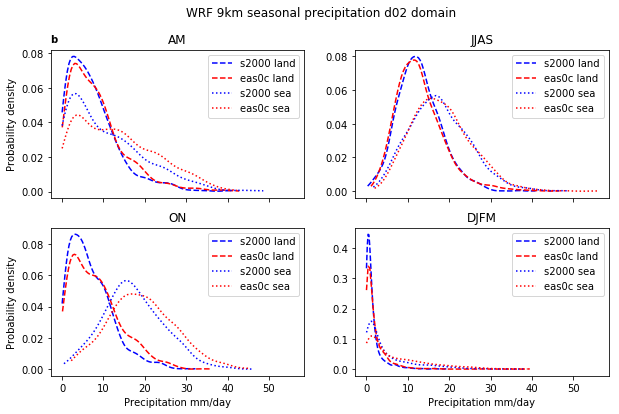

In [296]:
def plt_monsoon_pdf(ax,data1,data2,lnmsk,semsk,season_name):
    #plots pdf for the season that it is fed
    ax.set_title(season_name)
#     x=np.nanmean(data1.PPT,axis=(1,2))
#     plot_pdf(x,'s2000',ax,'b')
#     x2=np.nanmean(data2.PPT,axis=(1,2))
#     plot_pdf(x2,'eas0c',ax,'r')
    x3=np.nanmean(data1.PPT*lnmsk,axis=(1,2))
    plot_pdf(x3,'s2000 land',ax,'b--')
    x4=np.mean(data2.PPT*lnmsk,axis=(1,2))
    plot_pdf(x4,'eas0c land',ax,'r--')
    x5=np.mean(data1.PPT*semsk,axis=(1,2))
    plot_pdf(x5,'s2000 sea',ax,'b:')
    x6=np.mean(data2.PPT*semsk,axis=(1,2))
    plot_pdf(x6,'eas0c sea',ax,'r:')

#     ax[1,0].text(-0.1, 1.05, 'b', transform=ax[1,0].transAxes, 
#                 size=10, weight='bold')

def plot_monsoon_pdfs(data_s1,data_s2,lnmsk,semsk,index):
    #plots pdf for each season
    fig, ax = plt.subplots(2,2,sharex=True)
    s1_monsoon=monsoon(data_s1)
    s2_monsoon=monsoon(data_s2)
    axisgrids=[ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
    for ii in range(0,4):
        plt_monsoon_pdf(axisgrids[ii],s1_monsoon[ii],s2_monsoon[ii],lnmsk,semsk,my_xticks[ii])
        if(ii>1):
            axisgrids[ii].set_xlabel('Precipitation mm/day')
        if((ii+1)%2):
            axisgrids[ii].set_ylabel('Probability density')
    ax[0,0].text(0.0, 1.05, index, transform=ax[0,0].transAxes, 
                size=10, weight='bold')
        
plt.rcParams["figure.figsize"] = 10,6
my_xticks=['AM','JJAS','ON','DJFM']
plt.figure(1)
plot_monsoon_pdfs(s1_cesm_all,s2_cesm_all,landmask_cesm,seamask_cesm,'a')
plt.suptitle('CESM seasonal precipitation d01 domain')
plt.figure(2)
plot_monsoon_pdfs(s1_d01,s2_d01,landmask_d01,seamask_d01,'b')
plt.suptitle('WRF 27km seasonal precipitation d01 domain')
plt.figure(3)
plot_monsoon_pdfs(s1_d012,s2_d012,landmask_d012,seamask_d012,'a')
plt.suptitle('WRF 27km seasonal precipitation d02 domain')
plt.figure(4)
plot_monsoon_pdfs(s1_d02,s2_d02,landmask_d02,seamask_d02,'b')
plt.suptitle('WRF 9km seasonal precipitation d02 domain')
plt.show()

## Terrain Compaisons

#### Comparing land vs sea for CESM and WRF

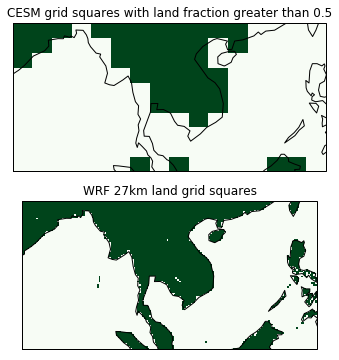

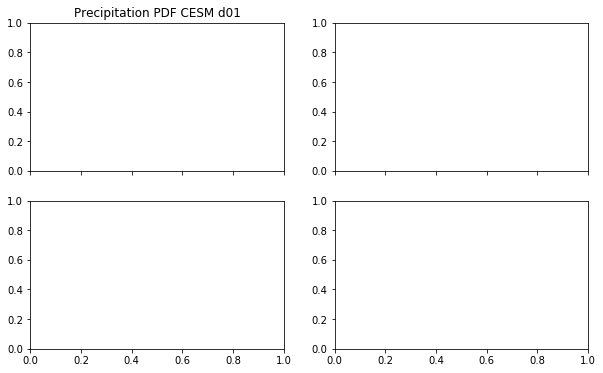

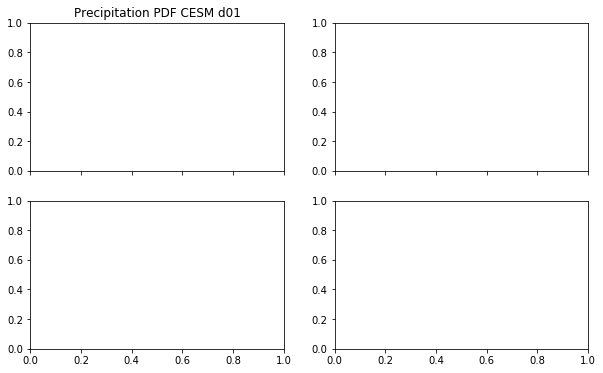

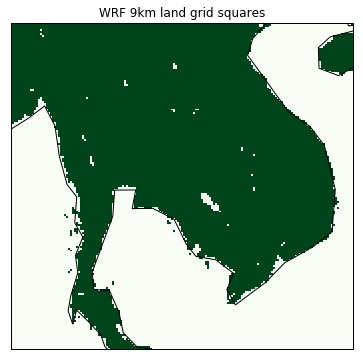

In [22]:
plt.figure(1)
plt.subplot(2,1,1,projection=ccrs.PlateCarree())
plt.pcolormesh(s1_cesm.lon,s1_cesm.lat,cesmlandfrac.LANDFRAC[0,:,:]>0.5,cmap='Greens')
# plt.colorbar(fraction=0.02)
ax=plt.gca()
ax.coastlines()
ax.set_extent([np.min(s1_cesm.lon), np.max(s1_cesm.lon), np.min(s1_cesm.lat), np.max(s1_cesm.lat)], crs=ccrs.PlateCarree())
plt.title('CESM grid squares with land fraction greater than 0.5')

plt.subplot(2,1,2,projection=ccrs.PlateCarree())
plt.pcolormesh(s1_d01.lon,s1_d01.lat,s1_d01.LANDMASK[0,:,:]>0.5,cmap='Greens')
# plt.colorbar(fraction=0.02)
ax=plt.gca()
ax.coastlines()
ax.set_extent([np.min(s1_d01.lon), np.max(s1_d01.lon), np.min(s1_d01.lat), np.max(s1_d01.lat)], crs=ccrs.PlateCarree())
plt.title('WRF 27km land grid squares')
plt.show()

plt.figure(2)
plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(s1_d02.lon,s1_d02.lat,s1_d02.LANDMASK[0,:,:]>0.5,cmap='Greens')
# plt.colorbar(fraction=0.02)
ax=plt.gca()
ax.coastlines()
ax.set_extent([np.min(s1_d02.lon), np.max(s1_d02.lon), np.min(s1_d02.lat), np.max(s1_d02.lat)], crs=ccrs.PlateCarree())
plt.title('WRF 9km land grid squares')
plt.show()

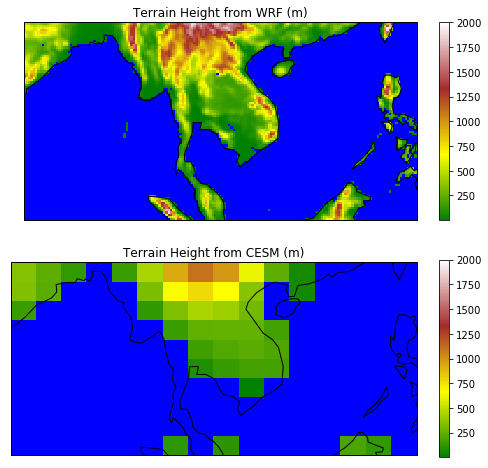

In [23]:
geo_d01=xr.open_dataset('/home/likkhian/dhobyghaut/cesm_output_convert/bcic/geo_em.d01.nc')
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams["figure.figsize"] = 8,8
mycmap = LinearSegmentedColormap.from_list('mycmap',['green','yellow','brown','white'])
mycmap.set_under('b')
plt.figure(1)
plt.subplot(2,1,1,projection=ccrs.PlateCarree())
landheight=s1_d01.LANDMASK[0,:,:].data*geo_d01.HGT_M[0,5:-5,5:-5].data
plt.pcolormesh(geo_d01.XLONG_M[0,5:-5,5:-5],geo_d01.XLAT_M[0,5:-5,5:-5],landheight, \
               vmin=1,vmax=2000,cmap=mycmap)
plt.colorbar(fraction=0.04, pad=0.05)
ax=plt.gca()
ax.set_extent([np.min(geo_d01.XLONG_M[0,5:-5,5:-5]), np.max(geo_d01.XLONG_M[0,5:-5,5:-5]), \
               np.min(geo_d01.XLAT_M[0,5:-5,5:-5]), np.max(geo_d01.XLAT_M[0,5:-5,5:-5])], \
              crs=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Terrain Height from WRF (m)')

# plt.figure(2)
cesm_hgt=(cesmlandfrac.LANDFRAC[0,:,:]>0.5)*cesm_geo.PHIS[-1,:,:]/9.8 #divide by gravity to get height
plt.subplot(2,1,2,projection=ccrs.PlateCarree())
plt.pcolormesh(s1_cesm.lon,s1_cesm.lat,cesm_hgt,vmin=1,vmax=2000,cmap=mycmap)
plt.colorbar(fraction=0.04, pad=0.05)
ax=plt.gca()
ax.set_extent([np.min(s1_cesm.lon), np.max(s1_cesm.lon), np.min(s1_cesm.lat), \
               np.max(s1_cesm.lat)], crs=ccrs.PlateCarree())


ax.coastlines()
ax.set_title('Terrain Height from CESM (m)')
plt.show()
# np.shape(cesm_geo.PHIS)

In [24]:
geo_d01=xr.open_dataset('/home/likkhian/dhobyghaut/cesm_output_convert/bcic/geo_em.d01.nc')
geo_d01

<xarray.Dataset>
Dimensions:     (Time: 1, land_cat: 21, month: 12, num_urb_params: 132, soil_cat: 16, south_north: 99, south_north_stag: 100, west_east: 180, west_east_stag: 181)
Dimensions without coordinates: Time, land_cat, month, num_urb_params, soil_cat, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times       (Time) |S19 b'0000-00-00_00:00:00'
    XLAT_M      (Time, south_north, west_east) float32 1.67043 1.67043 ...
    XLONG_M     (Time, south_north, west_east) float32 80.6577 80.9078 ...
    XLAT_V      (Time, south_north_stag, west_east) float32 1.54544 1.54544 ...
    XLONG_V     (Time, south_north_stag, west_east) float32 80.6577 80.9078 ...
    XLAT_U      (Time, south_north, west_east_stag) float32 1.67043 1.67043 ...
    XLONG_U     (Time, south_north, west_east_stag) float32 80.5327 80.7827 ...
    CLAT        (Time, south_north, west_east) float32 1.67043 1.67043 ...
    CLONG       (Time, south_north, west_east) float32 80.6577 80.9078

### Monsoon tests

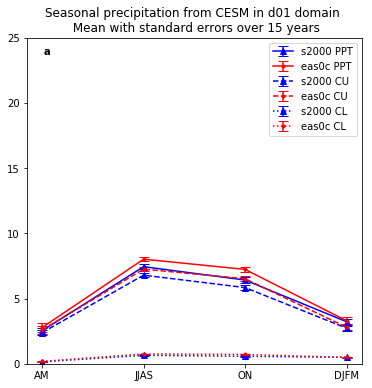

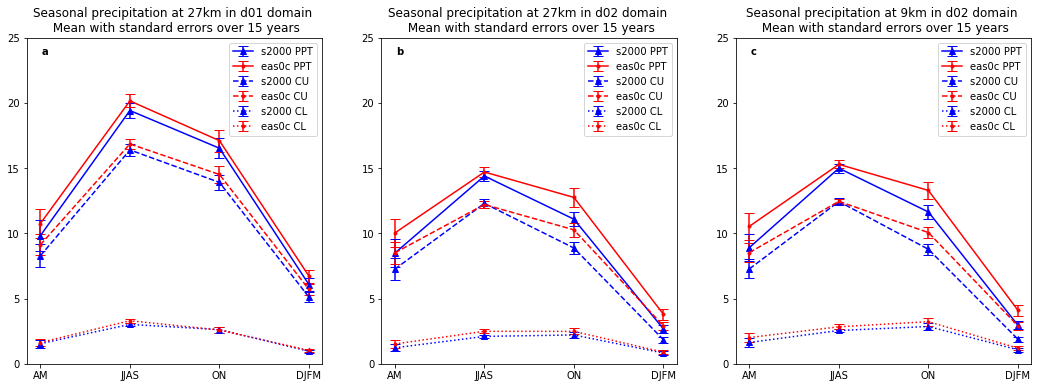

In [26]:
def plt_mon(s1,s2):
    t=np.arange(1,5)
    my_xticks=['AM','JJAS','ON','DJFM']
    plt.xticks([1,2,3,4],my_xticks)
    plt.ylim(0,25)
    
    s1_int2,s1_sum,s1_int1,s1_win,sems=monsoon(s1)
    s2_int2,s2_sum,s2_int1,s2_win,sems=monsoon(s2)
    
    def errorvectplots(pptvar,line,name):
        mean1=[]
        mean1.append(np.mean(s1_int2[pptvar]))
        mean1.append(np.mean(s1_sum[pptvar]))
        mean1.append(np.mean(s1_int1[pptvar]))
        mean1.append(np.mean(s1_win[pptvar]))
        mean2=[]
        mean2.append(np.mean(s2_int2[pptvar]))
        mean2.append(np.mean(s2_sum[pptvar]))
        mean2.append(np.mean(s2_int1[pptvar]))
        mean2.append(np.mean(s2_win[pptvar]))
        sem1=[]
        sem1.append(sem(np.mean(s1_int2[pptvar],axis=(1,2))))
        sem1.append(sem(np.mean(s1_sum[pptvar],axis=(1,2))))
        sem1.append(sem(np.mean(s1_int1[pptvar],axis=(1,2))))
        sem1.append(sem(np.mean(s1_win[pptvar],axis=(1,2))))
        sem2=[]
        sem2.append(sem(np.mean(s2_int2[pptvar],axis=(1,2))))
        sem2.append(sem(np.mean(s2_sum[pptvar],axis=(1,2))))
        sem2.append(sem(np.mean(s2_int1[pptvar],axis=(1,2))))
        sem2.append(sem(np.mean(s2_win[pptvar],axis=(1,2))))

        plt.errorbar(t,mean1,sem1, marker='^',capsize=5,color='b',ls=line,label='s2000 '+name)
        plt.errorbar(t,mean2,sem2, marker='.',capsize=5,color='r',ls=line,label='eas0c '+name)
#     plt.errorbar(t,np.mean(s1_qtr_cu,axis=(1,2)),s1_qtr_sem_cu, marker='^',capsize=5,color='b',ls='--',label='s2000 cu')
#     plt.errorbar(t,np.mean(s2_qtr_cu,axis=(1,2)),s2_qtr_sem_cu, marker='.',capsize=5,color='r',ls='--',label='eas0c cu')
#     plt.errorbar(t,np.mean(s1_qtr_cl,axis=(1,2)),s1_qtr_sem_cl, marker='^',capsize=5,color='b',ls=':',label='s2000 cl')
#     plt.errorbar(t,np.mean(s2_qtr_cl,axis=(1,2)),s2_qtr_sem_cl, marker='.',capsize=5,color='r',ls=':',label='eas0c cl')
    pptvars = ['PPT','RAINC','RAINNC']
    lines = ['-','--',':']
    names = ['PPT','CU','CL']
    for pptvar,line,name in zip(pptvars,lines,names):
        errorvectplots(pptvar,line,name)
plt.rcParams["figure.figsize"] = 6,6

plt.figure(1)
ax=plt.subplot()
plt_mon(s1_cesm_all,s2_cesm_all)
plt.title('Seasonal precipitation from CESM in d01 domain \n Mean with standard errors over 15 years')
plt.legend()
ax.text(0.05, 0.95, 'a', transform=ax.transAxes, 
                size=10, weight='bold')

plt.rcParams["figure.figsize"] = 18,6
plt.figure(2)
ax=plt.subplot(1,3,1)
plt_mon(s1_d01_mth,s2_d01_mth)
plt.title('Seasonal precipitation at 27km in d01 domain \n Mean with standard errors over 15 years')
plt.legend()
ax.text(0.05, 0.95, 'a', transform=ax.transAxes, 
                size=10, weight='bold')

ax=plt.subplot(1,3,2)
plt_mon(s1_d012_mth,s2_d012_mth)
plt.title('Seasonal precipitation at 27km in d02 domain \n Mean with standard errors over 15 years')
plt.legend()
ax.text(0.05, 0.95, 'b', transform=ax.transAxes, 
                size=10, weight='bold')

ax=plt.subplot(1,3,3)
plt_mon(s1_d02_mth,s2_d02_mth)
plt.title('Seasonal precipitation at 9km in d02 domain \n Mean with standard errors over 15 years')
plt.legend()
ax.text(0.05, 0.95, 'c', transform=ax.transAxes, 
                size=10, weight='bold')

plt.show()

### Calculate monsoonal seasonal spatial plots

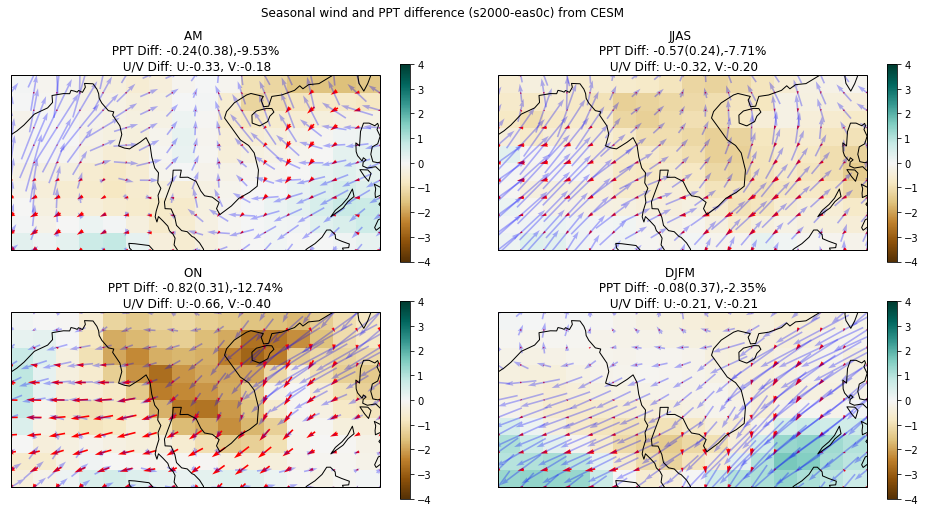

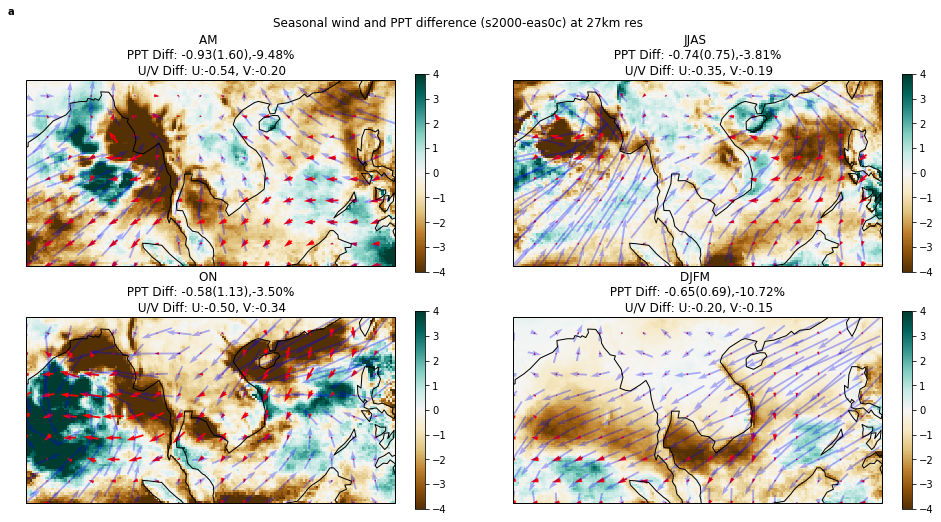

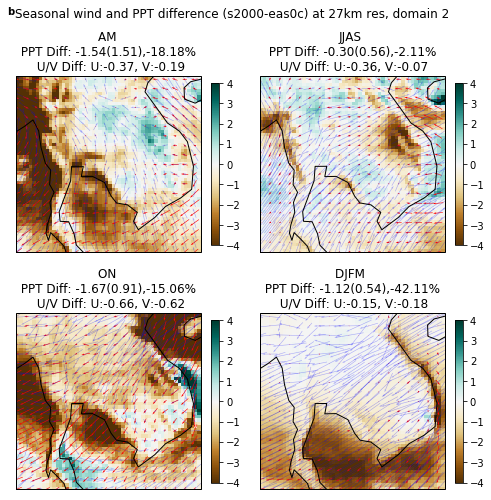

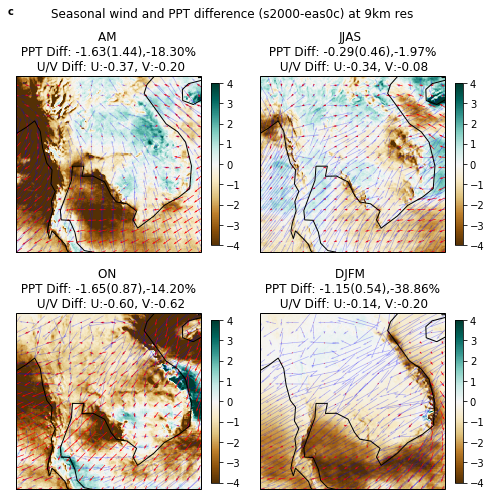

In [47]:
def monsoon_plots(s1,s2,ind,windy=False,cesm=False):
    s1_int2,s1_sum,s1_int1,s1_win,sems1=monsoon(s1)
    s2_int2,s2_sum,s2_int1,s2_win,sems2=monsoon(s2)
    ti,nlat,nlon=np.shape(s1.PPT)
    my_xticks=['JJAS','ON','DJFM','AM']
    # combine wind in each season into one array 4,lat,lon
    if cesm:
        s1U10=np.empty([4,nlat,nlon])
        s1U10[0,:,:]=np.mean(s1_sum.U10[:,-1,:,:],axis=0)
        s1U10[1,:,:]=np.mean(s1_int1.U10[:,-1,:,:],axis=0)
        s1U10[2,:,:]=np.mean(s1_win.U10[:,-1,:,:],axis=0)
        s1U10[3,:,:]=np.mean(s1_int2.U10[:,-1,:,:],axis=0)
        s1V10=np.empty([4,nlat,nlon])
        s1V10[0,:,:]=np.mean(s1_sum.V10[:,-1,:,:],axis=0)
        s1V10[1,:,:]=np.mean(s1_int1.V10[:,-1,:,:],axis=0)
        s1V10[2,:,:]=np.mean(s1_win.V10[:,-1,:,:],axis=0)
        s1V10[3,:,:]=np.mean(s1_int2.V10[:,-1,:,:],axis=0)
        s2U10=np.empty([4,nlat,nlon])
        s2U10[0,:,:]=np.mean(s2_sum.U10[:,-1,:,:],axis=0)
        s2U10[1,:,:]=np.mean(s2_int1.U10[:,-1,:,:],axis=0)
        s2U10[2,:,:]=np.mean(s2_win.U10[:,-1,:,:],axis=0)
        s2U10[3,:,:]=np.mean(s2_int2.U10[:,-1,:,:],axis=0)
        s2V10=np.empty([4,nlat,nlon])
        s2V10[0,:,:]=np.mean(s2_sum.V10[:,-1,:,:],axis=0)
        s2V10[1,:,:]=np.mean(s2_int1.V10[:,-1,:,:],axis=0)
        s2V10[2,:,:]=np.mean(s2_win.V10[:,-1,:,:],axis=0)
        s2V10[3,:,:]=np.mean(s2_int2.V10[:,-1,:,:],axis=0)
    else:
        s1U10=np.empty([4,nlat,nlon])
        s1U10[0,:,:]=np.mean(s1_sum.U10,axis=0)
        s1U10[1,:,:]=np.mean(s1_int1.U10,axis=0)
        s1U10[2,:,:]=np.mean(s1_win.U10,axis=0)
        s1U10[3,:,:]=np.mean(s1_int2.U10,axis=0)
        s1V10=np.empty([4,nlat,nlon])
        s1V10[0,:,:]=np.mean(s1_sum.V10,axis=0)
        s1V10[1,:,:]=np.mean(s1_int1.V10,axis=0)
        s1V10[2,:,:]=np.mean(s1_win.V10,axis=0)
        s1V10[3,:,:]=np.mean(s1_int2.V10,axis=0)
        s2U10=np.empty([4,nlat,nlon])
        s2U10[0,:,:]=np.mean(s2_sum.U10,axis=0)
        s2U10[1,:,:]=np.mean(s2_int1.U10,axis=0)
        s2U10[2,:,:]=np.mean(s2_win.U10,axis=0)
        s2U10[3,:,:]=np.mean(s2_int2.U10,axis=0)
        s2V10=np.empty([4,nlat,nlon])
        s2V10[0,:,:]=np.mean(s2_sum.V10,axis=0)
        s2V10[1,:,:]=np.mean(s2_int1.V10,axis=0)
        s2V10[2,:,:]=np.mean(s2_win.V10,axis=0)
        s2V10[3,:,:]=np.mean(s2_int2.V10,axis=0)

    if cesm:
        udiff=s1U10-s2U10
        vdiff=s1V10-s2V10
        ubase=s2U10
        vbase=s2V10
    elif windy:
        udiff=s1U10[:,::3,::3]-s2U10[:,::3,::3]
        vdiff=s1V10[:,::3,::3]-s2V10[:,::3,::3]
        ubase=s2U10[:,::3,::3]
        vbase=s2V10[:,::3,::3]
    else:
        udiff=s1U10[:,::10,::10]-s2U10[:,::10,::10]
        vdiff=s1V10[:,::10,::10]-s2V10[:,::10,::10]
        ubase=s2U10[:,::10,::10]
        vbase=s2V10[:,::10,::10]

    if cesm:
        slon1 = s1.lon
        slat1 = s1.lat       
    elif windy:
        slon1 = s1.lon[0::3]
        slat1 = s1.lat[0::3]
    else:
        slon1 = s1.lon[0::10]
        slat1 = s1.lat[0::10]
    cmap = plt.get_cmap('BrBG')
    vminn=-4
    vmaxx=4
    scale=8 # how scale affects length of vector: 1 m/s = 1 inch / scale
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=matplotlib.colors.Normalize(vmin=vminn, vmax=vmaxx))
    sm._A = []
    
    def draw_title(tt,pptdiff,s1_cur):
        return str('{} \n PPT Diff: {:.2f}({:.2f}),{:.2f}% \n U/V Diff: U:{:.2f}, V:{:.2f}'.format(my_xticks[tt],np.nanmean(pptdiff), \
                    add_sem(sems1[tt],sems2[tt]),np.nanmean(pptdiff)/np.nanmean(s1_cur)*100,float(np.mean(udiff[tt,:,:])),float(np.mean(vdiff[tt,:,:])) ))
#         return str('{} \n PPT Diff: {:.2f}({:.2f}), {:.2f}% \n U/V Diff: U:{:.2f}, V:{:.2f}'.format(my_xticks[tt],np.nanmean(pptdiff),\
#                 add_sem(s1_qtr_sem[tt],s2_qtr_sem[tt]), (np.nanmean(pptdiff[tt,:,:])/np.nanmean(s1_qtr[tt,:,:])*100), \
#                 float(np.mean(udiff[tt,:,:])),float(np.mean(vdiff[tt,:,:])) ))
    def draw_qtr_plt(ax,s1_cur,s2_cur,tt):
        pptdiff=np.mean(s1_cur.PPT-s2_cur.PPT,axis=0)
        ax.pcolormesh(s1_cur.lon, s1_cur.lat,pptdiff,vmin=vminn,vmax=vmaxx,cmap=cmap)
#         ax.pcolor(s1_mth.lon, s1_mth.lat, new_msk(s1_formsk[:,tt,:,:],s2_formsk[:,tt,:,:]), hatch='/', alpha=0.)
        ax.quiver(slon1,slat1,udiff[tt,:,:],vdiff[tt,:,:],pivot='middle',scale=scale,scale_units='inches',color='red')
        ax.quiver(slon1,slat1,ubase[tt,:,:],vbase[tt,:,:],pivot='middle',scale=scale,scale_units='inches',color='blue',alpha=0.3)
        ax.coastlines()
        ax.set_extent([np.min(s1.lon), np.max(s1.lon), np.min(s1.lat), np.max(s1.lat)], crs=ccrs.PlateCarree())
        plt.colorbar(sm,ax=ax,fraction=0.04, pad=0.05)
        ax.set_title(draw_title(tt,pptdiff,s1_cur.PPT))


    ax1=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
    draw_qtr_plt(ax1,s1_int2,s2_int2,3)
    ax2=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
    draw_qtr_plt(ax2,s1_sum,s2_sum,0)
    ax3=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
    draw_qtr_plt(ax3,s1_int1,s2_int1,1)
    ax4=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
    draw_qtr_plt(ax4,s1_win,s2_win,2)
#     plt.colorbar(sm,ax=ax,fraction=0.04, pad=0.05)   

    ax1.text(-0.05, 1.35, ind, transform=ax1.transAxes, 
                size=10, weight='bold')


plt.rcParams["figure.figsize"] = 16,8
plt.figure(1)
monsoon_plots(s1_cesm_all,s2_cesm_all,'',cesm=True)
plt.suptitle('Seasonal wind and PPT difference (s2000-eas0c) from CESM')

plt.figure(2)
monsoon_plots(s1_d01_mth,s2_d01_mth,'a')
plt.suptitle('Seasonal wind and PPT difference (s2000-eas0c) at 27km res')

plt.rcParams["figure.figsize"] = 8,8
plt.figure(3)
monsoon_plots(s1_d012_mth,s2_d012_mth,'b',windy=True)
plt.suptitle('Seasonal wind and PPT difference (s2000-eas0c) at 27km res, domain 2')

plt.figure(4)
monsoon_plots(s1_d02_mth,s2_d02_mth,'c')
plt.suptitle('Seasonal wind and PPT difference (s2000-eas0c) at 9km res')

plt.show()

## Cloud comparisons
It is a good idea to run this part separate from the above. Memory errors! <br>
Aside from looking at precipitation differences, clouds are also affected by dynamics.  
Would aerosols mean more clouds cause less rain? Or less clouds mean less rain!? Who knows.
z as calculated from wrf_usr_getvar is the height above msl of the middle of the grid point.

In [6]:

def grid_interval_height(zt):
    '''
    This function takes the z generated by ncl's wrf_usr_getvar
    and calculates the dz of the model aka the height of each model level
    '''
    dz=np.empty(np.shape(zt))
    ti,ht,la,lo=np.shape(zt)
    db=np.zeros([ti,la,lo])
    for i in range(ht):
        dz[:,i,:,:]=(zt[:,i,:,:]-db)*2
        db+=dz[:,i,:,:]
    return dz
    


In [175]:
def cloud_conc(df): #calculate cloud mass per m^2. Try first 13 levels (less than 20km)
    kg2g=1000
    if(np.min(df.QCLOUD)<0):
        raise RuntimeError('Ummm... something is wrong')
    else:
        return np.mean(np.sum(df.QCLOUD.data[:,:13,:,:]/df.ALT.data[:,:13,:,:]*df.dz.data[:,:13,:,:],axis=1),axis=0)*kg2g
    
def cloud_separater(file): #Reads in single file and returns seasonal column cloud mass per m^2
    c1_01=xr.open_dataset(file,autoclose=True)
    c1_01['dz']=(['time','lvl','lat','lon'],grid_interval_height(c1_01.z))
    #separate into monsoon seasons
    c1_01_int2,c1_01_sum,c1_01_int1,c1_01_win=monsoon(c1_01,ppt=False)
    cloud_seasons=[c1_01_int2,c1_01_sum,c1_01_int1,c1_01_win]
    calculated_cloud=[]
    for cloud in cloud_seasons:
        calculated_cloud.append(cloud_conc(cloud))
    return np.array(calculated_cloud)

def cloud_run_combiner(filenames): #combines seasonal cloud mass per m^2 for each data file
    allcloud=[]
    for file in filenames:
        allcloud.append(cloud_separater(file))
    return allcloud

def cloud_season_meaner(filenames): #find mean seasonal cloud mass per m^2 over all data files
    allcloud=cloud_run_combiner(filenames)
    for index,cloud in enumerate(allcloud):
        if(index==0):
            holder=cloud
        else:
            holder+=cloud
    return holder/(index+1)

def cloud_meaner(filenames): #calculate total column mean cloud mass per m^2
    allcloud=[]
    for file in filenames:
        df_cloud=xr.open_dataset(file,autoclose=True)
        df_cloud['dz']=(['time','lvl','lat','lon'],grid_interval_height(df_cloud.z))
        allcloud.append(cloud_conc(df_cloud))
    print(np.shape(allcloud),type(allcloud))
    return np.mean(np.array(allcloud),axis=0)

def cld_height_meaner(filenames):
    '''
    Calculates seasonal mean values for cloud mixing ratio keeping heights intact (not column sum)
    '''
    qcloudss=[]
    zss=[]
    for file in filenames:
        print(file)
        cloud_season=monsoon(xr.open_dataset(file,autoclose=True),ppt=False)
        qclouds=[]
        zs=[]
        for season in cloud_season:
            qcloud=np.mean(season.QCLOUD.data,axis=0)
            qclouds.append(qcloud)
            z=np.mean(season.z.data,axis=0)
            zs.append(z)
        qcloudss.append(np.array(qclouds))
        zss.append(np.array(zs))
    return np.mean(np.array(qcloudss),axis=0),np.mean(np.array(zss),axis=0)


def seasonal_height_meaner(filenames,variables):
    '''Calculates seasonal mean values for a list of variables'''
    allresults=[]
    for file in filenames:
        print('working on file ',file)
        data_seasons=monsoon(xr.open_dataset(file,autoclose=True),ppt=False)
        varresults=[]
        for variable in variables:
            print('working on var ',variable)
            holder=[]
            for season in data_seasons:
                meanval=np.mean(season[variable].data,axis=0)
                holder.append(meanval)
            varresults.append(holder)
        allresults.append(np.array(varresults))
    return np.mean(np.array(allresults),axis=0)
        

In [9]:
cloudlist_s1=['../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_01_d01_TPCV.nc',\
          '../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_02_d01_TPCV.nc',\
          '../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_03_d01_TPCV.nc']

cloudlist_s2=['../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_01_d01_TPCV.nc',\
             '../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_02_d01_TPCV.nc',\
             '../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_03_d01_TPCV.nc']

c1_01=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_01_d01_TPCV.nc',autoclose=True)
lons=c1_01.lon
lats=c1_01.lat

#seasonal column cloud calculations
c1=cloud_season_meaner(cloudlist_s1)
c2=cloud_season_meaner(cloudlist_s2)
cloud_diff=c1-c2

#total cloud calculations
c1_mean=cloud_meaner(cloudlist_s1)
c2_mean=cloud_meaner(cloudlist_s2)

#cloud height calculations
#average across time, leaving levels intact
c1_height_qcloud,c1_height_z=cld_height_meaner(cloudlist_s1)
c2_height_qcloud,c2_height_z=cld_height_meaner(cloudlist_s2)

# print(np.mean(cloud_diff),np.shape(cloud_diff))

In [307]:
s1_temps=['../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_2000_01_d01_tk.nc',\
          '../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_2000_02b_d01_tk.nc',\
          '../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_2000_03_d01_tk.nc']

s2_temps=['../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_eas0c_01_d01_tk.nc',\
             '../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_eas0c_02b_d01_tk.nc',\
             '../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_eas0c_03_d01_tk.nc']

#calculate temp across time and space
c1_height_t=np.squeeze(seasonal_height_meaner(s1_temps,['tk']))
c2_height_t=np.squeeze(seasonal_height_meaner(s2_temps,['tk']))

working on file  ../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_2000_01_d01_tk.nc
working on var  tk
working on file  ../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_2000_02b_d01_tk.nc
working on var  tk
working on file  ../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_2000_03_d01_tk.nc
working on var  tk
working on file  ../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_eas0c_01_d01_tk.nc
working on var  tk
working on file  ../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_eas0c_02b_d01_tk.nc
working on var  tk
working on file  ../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_eas0c_03_d01_tk.nc
working on var  tk


### Other hydrometers

In [190]:
%%time
s1_hydrometers=['../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_01_d01_qigrs.nc',\
          '../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_02b_d01_qigrs.nc',\
          '../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_03_d01_qigrs.nc']

s2_hydrometers=['../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_01_d01_qigrs.nc',\
             '../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_02b_d01_qigrs.nc',\
             '../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_03_d01_qigrs.nc']

#calculate temp across time and space
c1_height_hydrometers=seasonal_height_meaner(s1_hydrometers,['QICE','QSNOW','QGRAUP','QRAIN'])
c2_height_hydrometers=seasonal_height_meaner(s2_hydrometers,['QICE','QSNOW','QGRAUP','QRAIN'])


working on file  ../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_01_d01_qigrs.nc
working on var  QICE
working on var  QSNOW
working on var  QGRAUP
working on var  QRAIN
working on file  ../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_02b_d01_qigrs.nc
working on var  QICE
working on var  QSNOW
working on var  QGRAUP
working on var  QRAIN
working on file  ../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_03_d01_qigrs.nc
working on var  QICE
working on var  QSNOW
working on var  QGRAUP
working on var  QRAIN
working on file  ../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_01_d01_qigrs.nc
working on var  QICE
working on var  QSNOW
working on var  QGRAUP
working on var  QRAIN
working on file  ../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_02b_d01_qigrs.nc
working on var  QICE
working on var  QSNOW
working on var  QGRAUP
working on var  QRAIN
working on file  ../cesm_output_convert/analysis/downsca

Plot seasonal cloud differences

In [ ]:
def cloud_plots(c1,c2,ind):
    ti,nlat,nlon=np.shape(c1)
    my_xticks=['AM','JJAS','ON','DJFM']

    cmap = plt.get_cmap('BrBG')
    vminn=-100
    vmaxx=100
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=matplotlib.colors.Normalize(vmin=vminn, vmax=vmaxx))
    sm._A = []
    
    def draw_title(tt,clouddiff,s1):
        return str('{} \n Cloud Diff: {:.2f}, {:.2f}%'.format(my_xticks[tt],np.nanmean(clouddiff),np.nanmean(clouddiff)/np.nanmean(s1)*100))
#         return str('{} \n PPT Diff: {:.2f}({:.2f}), {:.2f}% \n U/V Diff: U:{:.2f}, V:{:.2f}'.format(my_xticks[tt],np.nanmean(pptdiff),\
#                 add_sem(s1_qtr_sem[tt],s2_qtr_sem[tt]), (np.nanmean(pptdiff[tt,:,:])/np.nanmean(s1_qtr[tt,:,:])*100), \
#                 float(np.mean(udiff[tt,:,:])),float(np.mean(vdiff[tt,:,:])) ))
    def draw_qtr_plt(ax,s1,s2,tt):
        print('shape of plt',np.shape(s1),np.shape(s1[tt]))
        diff=s1-s2
        ax.pcolormesh(lons, lats,diff,vmin=vminn,vmax=vmaxx,cmap=cmap)
#         ax.pcolor(s1_mth.lon, s1_mth.lat, new_msk(s1_formsk[:,tt,:,:],s2_formsk[:,tt,:,:]), hatch='/', alpha=0.)
        ax.coastlines()
        ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())
        plt.colorbar(sm,ax=ax,fraction=0.04, pad=0.05)
        ax.set_title(draw_title(tt,diff,s1))


    ax1=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
    draw_qtr_plt(ax1,c1[0,:,:],c2[0,:,:],0)
    ax2=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
    draw_qtr_plt(ax2,c1[1,:,:],c2[1,:,:],1)
    ax3=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
    draw_qtr_plt(ax3,c1[2,:,:],c2[2,:,:],2)
    ax4=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
    draw_qtr_plt(ax4,c1[3,:,:],c2[3,:,:],3)
    plt.colorbar(sm,ax=ax,fraction=0.04, pad=0.05)   

    ax1.text(0.0, 1.05, 'a', transform=ax1.transAxes, 
                size=10, weight='bold')
    ax1.text(0.0, 1.05, 'b', transform=ax2.transAxes, 
                size=10, weight='bold')
    ax1.text(0.0, 1.05, 'c', transform=ax3.transAxes, 
                size=10, weight='bold')
    ax1.text(0.0, 1.05, 'd', transform=ax4.transAxes, 
                size=10, weight='bold')

shape of plt (89, 170) (170,)
shape of plt (89, 170) (170,)
shape of plt (89, 170) (170,)
shape of plt (89, 170) (170,)


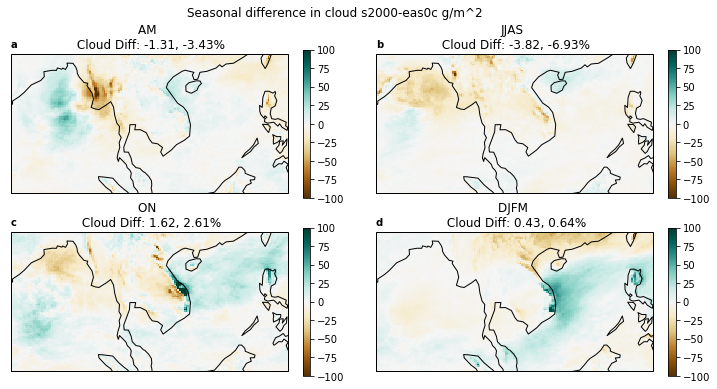

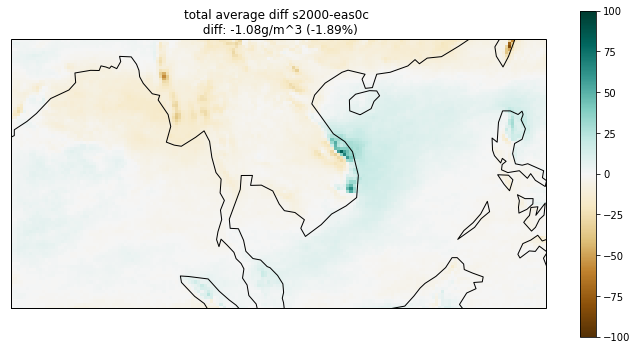

In [57]:
#this with first 13 levels
plt.rcParams["figure.figsize"] = 12,6
plt.figure(1)
cloud_plots(c1,c2,'')
plt.suptitle('Seasonal difference in cloud s2000-eas0c g/m^2')

plt.figure(2)
plt.subplot(projection=ccrs.PlateCarree())
plt.pcolormesh(lons,lats,c1_mean-c2_mean,vmin=-100,vmax=100,cmap='BrBG')
plt.colorbar()
ax=plt.gca()
ax.coastlines()
ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())
ax.set_title('total average diff s2000-eas0c \n diff: {:.2f}g/m^3 ({:.2f}%)'.format(np.mean(c1_mean-c2_mean),np.mean(c1_mean-c2_mean)/np.mean(c1_mean)*100))

plt.show()

### Plot average mixing ratios with height for each season

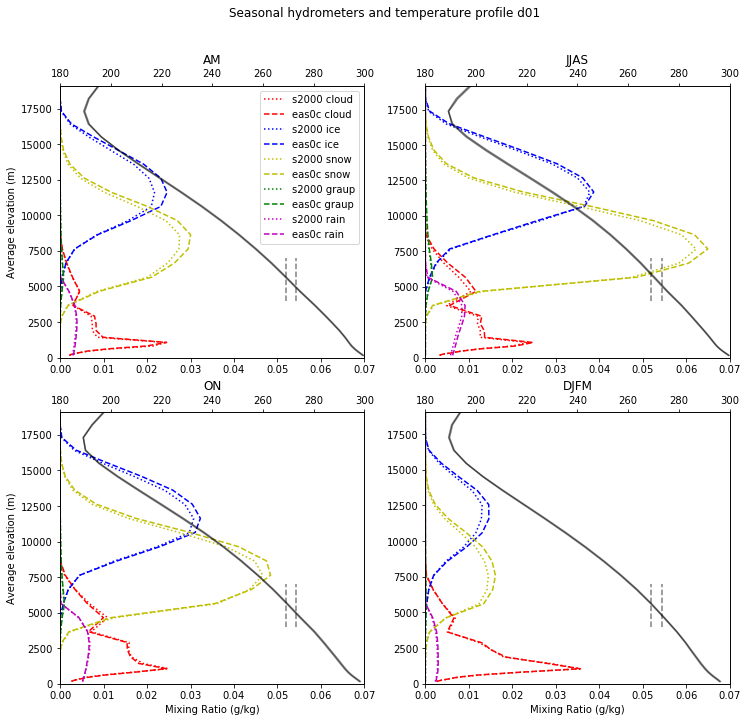

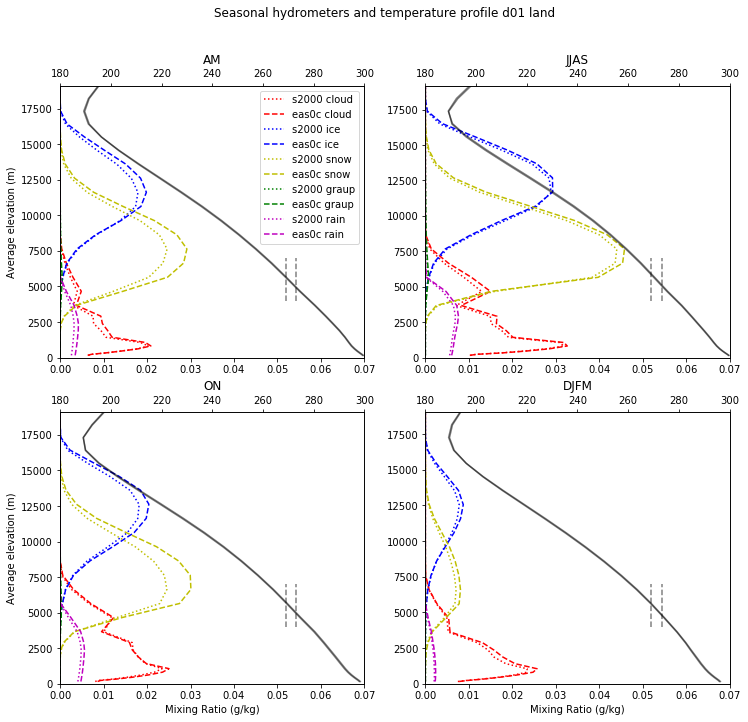

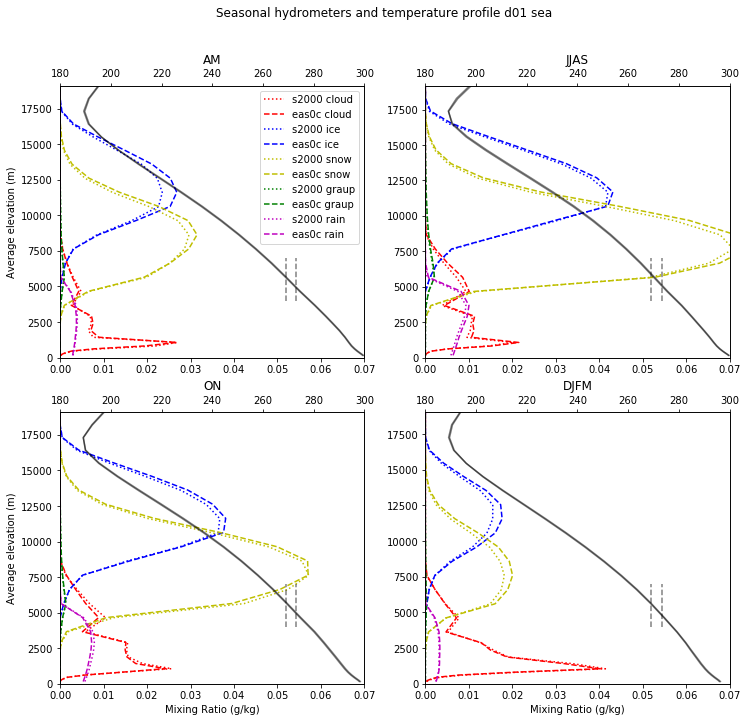

In [323]:
plt.rcParams["figure.figsize"] = 12,11 #10,11

def plotcloudheight(qcloud,cloud_z,linestyle,label,level,mask=1):
    for ii,cld in enumerate(qcloud):
        plt.subplot(2,2,ii+1)

        plt.plot(np.nanmean(cld*1000*mask,axis=(1,2))[:level],(np.mean(cloud_z[ii,:,:,:],axis=(1,2)))[:level],linestyle,label=label)
#         plt.plot(np.nanmean(cld*1000*mask,axis=(1,2))[:15],np.arange(15),linestyle,label=label)
#         plt.plot([1,15,2,14,3,13,4,12,5,11,6,10,7,9,8],cum_hgt(np.mean(cloud_z[ii,:,:,:],axis=(1,2))[:15]),linestyle,label=label)
        if((ii+1)%2):
            plt.ylabel('Average elevation (m)')
        if(ii>1):
            plt.xlabel('Mixing Ratio (g/kg)')
        plt.xlim([0,0.07])

#         plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
def plotcloudtemp(s1_cloud_t,s2_cloud_t,s1_cloud_z,s2_cloud_z,level):
    for ii,cld in enumerate(s1_cloud_t):
        plt.subplot(2,2,ii+1)
        plt.title(my_xticks[ii],y=1.06)
        ax=plt.gca()
        ax2=ax.twiny()
        ax2.plot(np.nanmean(s1_cloud_t[ii,:,:,:],axis=(1,2))[:level],(np.mean(s1_cloud_z[ii,:,:,:],axis=(1,2)))[:level],'k',alpha=0.5,label='s2000')
        ax2.plot(np.nanmean(s2_cloud_t[ii,:,:,:],axis=(1,2))[:level],(np.mean(s2_cloud_z[ii,:,:,:],axis=(1,2)))[:level],'k',alpha=0.5,label='eas0c')
        ax2.plot((273.15,273.15),(4000,7000),'k--',alpha=0.5)
        ax2.plot((269.15,269.15),(4000,7000),'k--',alpha=0.5)
        ax2.set_ylim(ymin=0,ymax=np.max((np.mean(s1_cloud_z[ii,:,:,:],axis=(1,2)))[:level]))
        ax2.set_xlim((180,300))

#         ax2.plot(np.ones(15)*273.15,(np.mean(s2_cloud_z[ii,:,:,:],axis=(1,2)))[:15],'k',label='eas0c')

my_xticks=['AM','JJAS','ON','DJFM']
# plt.figure(1)
# plt.suptitle('Seasonal cloud and temperature profile d01')
# plotcloudheight(c1_height_qcloud,c1_height_z,'r','s2000',15)
# plotcloudheight(c2_height_qcloud,c2_height_z,'b','eas0c',15)
# plotcloudheight(c1_height_qcloud,c1_height_z,'r:','s2000 land',15,mask=landmsk[0,:,:])
# plotcloudheight(c2_height_qcloud,c2_height_z,'b:','eas0c land',15,mask=landmsk[0,:,:])
# plt.subplot(2,2,1)
# plt.legend()
# plotcloudtemp(c1_height_t,c2_height_t,c1_height_z,c2_height_z,15)

plt.figure(2)
level=28
plt.suptitle('Seasonal hydrometers and temperature profile d01')
plotcloudheight(c1_height_qcloud,c1_height_z,'r:','s2000 cloud',level)
plotcloudheight(c2_height_qcloud,c2_height_z,'r--','eas0c cloud',level)
plotcloudheight(c1_height_hydrometers[0,:,:,:],c1_height_z,'b:','s2000 ice',level)
plotcloudheight(c2_height_hydrometers[0,:,:,:],c2_height_z,'b--','eas0c ice',level)
plotcloudheight(c1_height_hydrometers[1,:,:,:],c1_height_z,'y:','s2000 snow',level)
plotcloudheight(c2_height_hydrometers[1,:,:,:],c2_height_z,'y--','eas0c snow',level)
plotcloudheight(c1_height_hydrometers[2,:,:,:],c1_height_z,'g:','s2000 graup',level)
plotcloudheight(c2_height_hydrometers[2,:,:,:],c2_height_z,'g--','eas0c graup',level)
plotcloudheight(c1_height_hydrometers[3,:,:,:],c1_height_z,'m:','s2000 rain',level)
plotcloudheight(c2_height_hydrometers[3,:,:,:],c2_height_z,'m--','eas0c rain',level)
plt.subplot(2,2,1)
plt.legend()
plotcloudtemp(c1_height_t,c2_height_t,c1_height_z,c2_height_z,level)

plt.figure(3)
level=28
plt.suptitle('Seasonal hydrometers and temperature profile d01 land')
plotcloudheight(c1_height_qcloud,c1_height_z,'r:','s2000 cloud',level,landmsk_d01[0,:,:])
plotcloudheight(c2_height_qcloud,c2_height_z,'r--','eas0c cloud',level,landmsk_d01[0,:,:])
plotcloudheight(c1_height_hydrometers[0,:,:,:],c1_height_z,'b:','s2000 ice',level,landmsk_d01[0,:,:])
plotcloudheight(c2_height_hydrometers[0,:,:,:],c2_height_z,'b--','eas0c ice',level,landmsk_d01[0,:,:])
plotcloudheight(c1_height_hydrometers[1,:,:,:],c1_height_z,'y:','s2000 snow',level,landmsk_d01[0,:,:])
plotcloudheight(c2_height_hydrometers[1,:,:,:],c2_height_z,'y--','eas0c snow',level,landmsk_d01[0,:,:])
plotcloudheight(c1_height_hydrometers[2,:,:,:],c1_height_z,'g:','s2000 graup',level,landmsk_d01[0,:,:])
plotcloudheight(c2_height_hydrometers[2,:,:,:],c2_height_z,'g--','eas0c graup',level,landmsk_d01[0,:,:])
plotcloudheight(c1_height_hydrometers[3,:,:,:],c1_height_z,'m:','s2000 rain',level,landmsk_d01[0,:,:])
plotcloudheight(c2_height_hydrometers[3,:,:,:],c2_height_z,'m--','eas0c rain',level,landmsk_d01[0,:,:])
plt.subplot(2,2,1)
plt.legend()
plotcloudtemp(c1_height_t,c2_height_t,c1_height_z,c2_height_z,level)

plt.figure(4)
level=28
plt.suptitle('Seasonal hydrometers and temperature profile d01 sea')
plotcloudheight(c1_height_qcloud,c1_height_z,'r:','s2000 cloud',level,seamsk[0,:,:])
plotcloudheight(c2_height_qcloud,c2_height_z,'r--','eas0c cloud',level,seamsk[0,:,:])
plotcloudheight(c1_height_hydrometers[0,:,:,:],c1_height_z,'b:','s2000 ice',level,seamsk[0,:,:])
plotcloudheight(c2_height_hydrometers[0,:,:,:],c2_height_z,'b--','eas0c ice',level,seamsk[0,:,:])
plotcloudheight(c1_height_hydrometers[1,:,:,:],c1_height_z,'y:','s2000 snow',level,seamsk[0,:,:])
plotcloudheight(c2_height_hydrometers[1,:,:,:],c2_height_z,'y--','eas0c snow',level,seamsk[0,:,:])
plotcloudheight(c1_height_hydrometers[2,:,:,:],c1_height_z,'g:','s2000 graup',level,seamsk[0,:,:])
plotcloudheight(c2_height_hydrometers[2,:,:,:],c2_height_z,'g--','eas0c graup',level,seamsk[0,:,:])
plotcloudheight(c1_height_hydrometers[3,:,:,:],c1_height_z,'m:','s2000 rain',level,seamsk[0,:,:])
plotcloudheight(c2_height_hydrometers[3,:,:,:],c2_height_z,'m--','eas0c rain',level,seamsk[0,:,:])
plt.subplot(2,2,1)
plt.legend()
plotcloudtemp(c1_height_t,c2_height_t,c1_height_z,c2_height_z,level)

# plotcloudheight(c1_height_qcloud,c1_height_z,'r--',mask=seamsk[0,:,:])
# plotcloudheight(c2_height_qcloud,c1_height_z,'b--',mask=seamsk[0,:,:])
plt.show()  

### Plot hydrometers for calibration d01

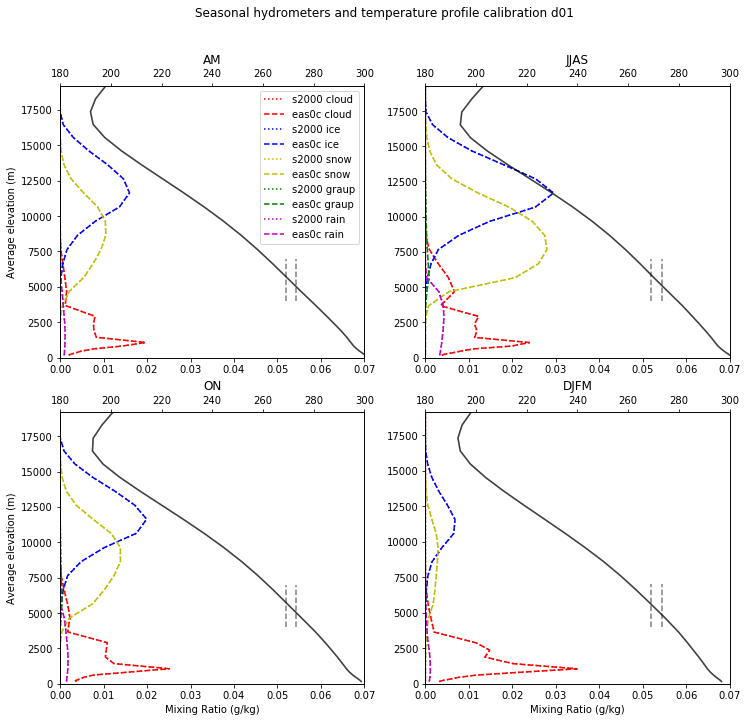

In [304]:
plt.rcParams["figure.figsize"] = 12,11
# calibration_hydrometers=seasonal_height_meaner(['../cesm_output_convert/analysis/wrfpost_run_calibration_d01.nc'],\
#                                                ['QICE','QSNOW','QGRAUP','QRAIN','QCLOUD','tk','z'])
plt.figure(1)
level=28
plt.suptitle('Seasonal hydrometers and temperature profile calibration d01')
plotcloudheight(calibration_hydrometers[4,:,:,:],calibration_hydrometers[6,:,:,:],'r:','s2000 cloud',level)
plotcloudheight(calibration_hydrometers[4,:,:,:],calibration_hydrometers[6,:,:,:],'r--','eas0c cloud',level)
plotcloudheight(calibration_hydrometers[0,:,:,:],calibration_hydrometers[6,:,:,:],'b:','s2000 ice',level)
plotcloudheight(calibration_hydrometers[0,:,:,:],calibration_hydrometers[6,:,:,:],'b--','eas0c ice',level)
plotcloudheight(calibration_hydrometers[1,:,:,:],calibration_hydrometers[6,:,:,:],'y:','s2000 snow',level)
plotcloudheight(calibration_hydrometers[1,:,:,:],calibration_hydrometers[6,:,:,:],'y--','eas0c snow',level)
plotcloudheight(calibration_hydrometers[2,:,:,:],calibration_hydrometers[6,:,:,:],'g:','s2000 graup',level)
plotcloudheight(calibration_hydrometers[2,:,:,:],calibration_hydrometers[6,:,:,:],'g--','eas0c graup',level)
plotcloudheight(calibration_hydrometers[3,:,:,:],calibration_hydrometers[6,:,:,:],'m:','s2000 rain',level)
plotcloudheight(calibration_hydrometers[3,:,:,:],calibration_hydrometers[6,:,:,:],'m--','eas0c rain',level)
plt.subplot(2,2,1)
plt.legend()
plotcloudtemp(calibration_hydrometers[5,:,:,:],calibration_hydrometers[5,:,:,:],calibration_hydrometers[6,:,:,:],calibration_hydrometers[6,:,:,:],level)
plt.show()  

### plot hydrometers for d02

### Scatter plot of heights! 
landmsk or seamsk can be used to differentiate.

In [76]:
#plot scatter plot of heights
ctest=xr.open_dataset(cloudlist_s1[0])
ctest2=xr.open_dataset(s1_temps[0])
print(ctest,ctest2)

# plt.scatter((c1_height_qcloud)[0,:15,:,:].flatten()*1000,c1_z_cum[0,:15,:,:].flatten(),s=0.001,c='b',alpha=0.5)
# aa=(c2_height_qcloud)[0,:15,:,:].flatten()*1000 #landmsk[0,:,:]*
# bb=c1_height_z[0,:15,:,:].flatten()
# plt.scatter(aa[aa > 0.001],bb[aa > 0.001],s=0.001,c='r',alpha=0.5)
plt.show()

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 170, lvl: 29, time: 1825)
Coordinates:
  * time     (time) datetime64[ns] 2050-01-01 2050-01-02 2050-01-03 ...
  * lvl      (lvl) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat      (lat) float32 2.91971 3.16941 3.41906 3.66864 3.91816 4.16759 ...
  * lon      (lon) float32 81.908 82.1581 82.4081 82.6582 82.9083 83.1583 ...
Data variables:
    T        (time, lvl, lat, lon) float64 -0.743 -0.7641 -0.6728 -0.6861 ...
    ALT      (time, lvl, lat, lon) float64 0.8779 0.8776 0.8778 0.8775 ...
    z        (time, lvl, lat, lon) float64 29.9 29.9 29.9 29.9 29.89 29.89 ...
    QCLOUD   (time, lvl, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    QVAPOR   (time, lvl, lat, lon) float64 0.01682 0.01668 0.01658 0.01641 ...
    P        (time, lvl, lat, lon) float64 1.006e+03 1.008e+03 1.007e+03 ...
Attributes:
    history:                         Mon Mar  5 12:27:32 2018: ncks -A -x /ho...
    NCO:                       

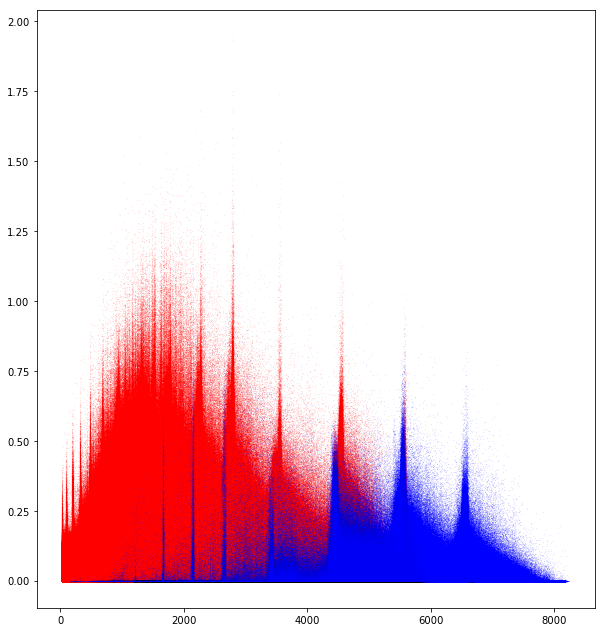

In [81]:
# aa=ctest['QCLOUD'][:,:15,:,:].data.flatten()*1000
# bb=ctest['z'][:,:15,:,:].data.flatten()
# cc=ctest2['tk'][:,:15,:,:].data.flatten()
# aacc_warm=aa[cc>273.15]
# aabb_warm=bb[cc>273.15]
# aacc_cold=aa[cc<273.15]
# aabb_cold=bb[cc<273.15]
plt.scatter(aabb_warm,aacc_warm,s=0.001,c='r')
plt.scatter(aabb_cold,aacc_cold,s=0.001,c='b')
plt.show()

### Plot the spatial estimated cloud heights for each season
cloud heights are estimated by looking for the largest value of the cloud water mixing ratio and taking it's height.
Assumes that there is only a single cloud on average over each point and it has a max height.

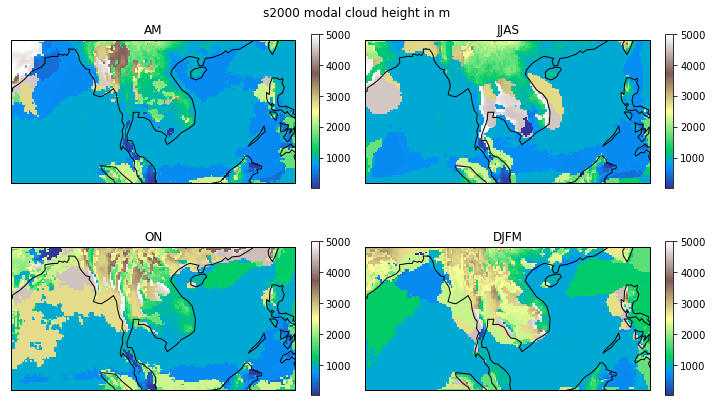

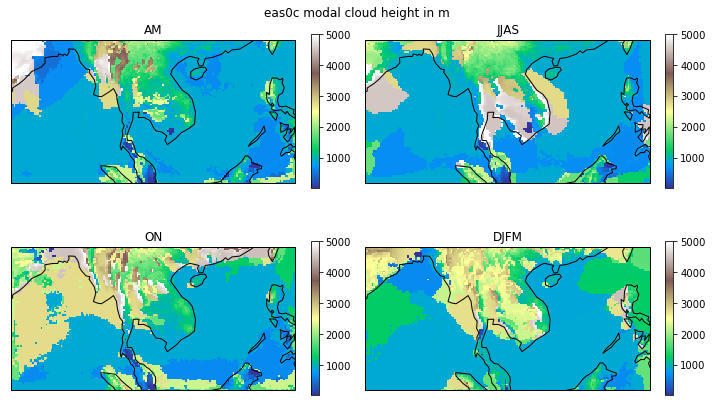

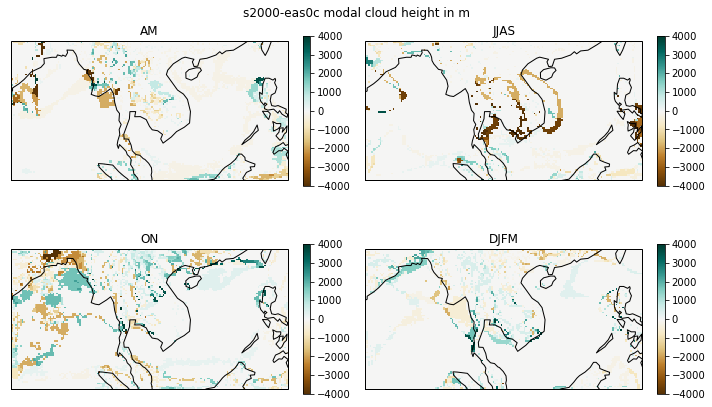

In [53]:
plt.rcParams["figure.figsize"] = 10,6
hgt_ind=30 #limit the model height betwen 0 and 29
def z_mode(array,zarray,axis):
    args=np.argmax(array,axis)
    return args.choose(zarray)
plt.figure(1)
for ii,cld in enumerate(c1_height_qcloud):
    plt.subplot(2,2,ii+1,projection=ccrs.PlateCarree())
    z_chosen_c1=z_mode(cld[:hgt_ind,:,:],c1_height_z[ii,:hgt_ind,:,:],axis=0)
    plt.pcolormesh(c1_01.lon,c1_01.lat,z_chosen_c1,cmap='terrain',vmax=5000)
    plt.colorbar(fraction=0.025)
    plt.title(my_xticks[ii])
    ax=plt.gca()
    ax.coastlines()
    ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())
plt.suptitle('s2000 modal cloud height in m')
plt.tight_layout()
plt.figure(2)
for ii,cld in enumerate(c2_height_qcloud):
    plt.subplot(2,2,ii+1,projection=ccrs.PlateCarree())
    z_chosen_c2=z_mode(cld[:hgt_ind,:,:],c2_height_z[ii,:hgt_ind,:,:],axis=0)
    plt.pcolormesh(lons,lats,z_chosen_c2,cmap='terrain',vmax=5000)
    plt.colorbar(fraction=0.025)
    plt.title(my_xticks[ii])
    ax=plt.gca()
    ax.coastlines()
    ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())
plt.suptitle('eas0c modal cloud height in m')
plt.tight_layout()
plt.figure(3)
for ii,cld in enumerate(c1_height_qcloud):
    plt.subplot(2,2,ii+1,projection=ccrs.PlateCarree())
    z_chosen_c1=z_mode(cld[:hgt_ind,:,:],c1_height_z[ii,:hgt_ind,:,:],axis=0)
    z_chosen_c2=z_mode(c2_height_qcloud[ii,:hgt_ind,:,:],c2_height_z[ii,:hgt_ind,:,:],axis=0)
    plt.pcolormesh(lons,lats,z_chosen_c1-z_chosen_c2,cmap='BrBG',vmin=-4000,vmax=4000)
#     plt.pcolormesh(lons,lats,argmedian(cld[:hgt_ind,:,:],axis=0)-argmedian(c2_height_qcloud[ii,:15,:,:],axis=0),cmap='BrBG')
    plt.colorbar(fraction=0.025)
    plt.title(my_xticks[ii])
    ax=plt.gca()
    ax.coastlines()
    ax.set_extent([np.min(lons), np.max(lons), np.min(lats), np.max(lats)], crs=ccrs.PlateCarree())
plt.suptitle('s2000-eas0c modal cloud height in m')
plt.tight_layout()
plt.show()

## Water vapor flux

In [258]:
# c1_01.QVAPOR
# uwind=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_2000_01_d01_U.nc')
# vwind=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_2000_01_d01_V.nc')

vlist_s1=['../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_2000_01_d01_V.nc',\
          '../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_2000_02_d01_V.nc',\
          '../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_2000_03_d01_V.nc']
ulist_s1=['../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_2000_01_d01_U.nc',\
          '../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_2000_02_d01_U.nc',\
          '../cesm_output_convert/analysis/downscale_results/hello/wrfpost_run_2000_03_d01_U.nc']

In [197]:
print(np.shape(uwind.U))
print(np.shape(vwind.V))
print(np.shape(c1_01.QVAPOR))

(1825, 29, 89, 171)
(1825, 29, 90, 170)
(1825, 29, 89, 170)


../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_01_d01_TPCV.nc
1  (305, 88, 169) <class 'xarray.core.dataarray.DataArray'>
2  (1, 88, 169) <class 'list'>
1  (610, 88, 169) <class 'xarray.core.dataarray.DataArray'>
2  (2, 88, 169) <class 'list'>
1  (305, 88, 169) <class 'xarray.core.dataarray.DataArray'>
2  (3, 88, 169) <class 'list'>
1  (605, 88, 169) <class 'xarray.core.dataarray.DataArray'>
2  (4, 88, 169) <class 'list'>
3  (1, 4, 88, 169) <class 'list'>
../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_02_d01_TPCV.nc
1  (305, 88, 169) <class 'xarray.core.dataarray.DataArray'>
2  (1, 88, 169) <class 'list'>
1  (610, 88, 169) <class 'xarray.core.dataarray.DataArray'>
2  (2, 88, 169) <class 'list'>
1  (305, 88, 169) <class 'xarray.core.dataarray.DataArray'>
2  (3, 88, 169) <class 'list'>
1  (605, 88, 169) <class 'xarray.core.dataarray.DataArray'>
2  (4, 88, 169) <class 'list'>
3  (2, 4, 88, 169) <class 'list'>
../cesm_output_convert/analysis/downscal

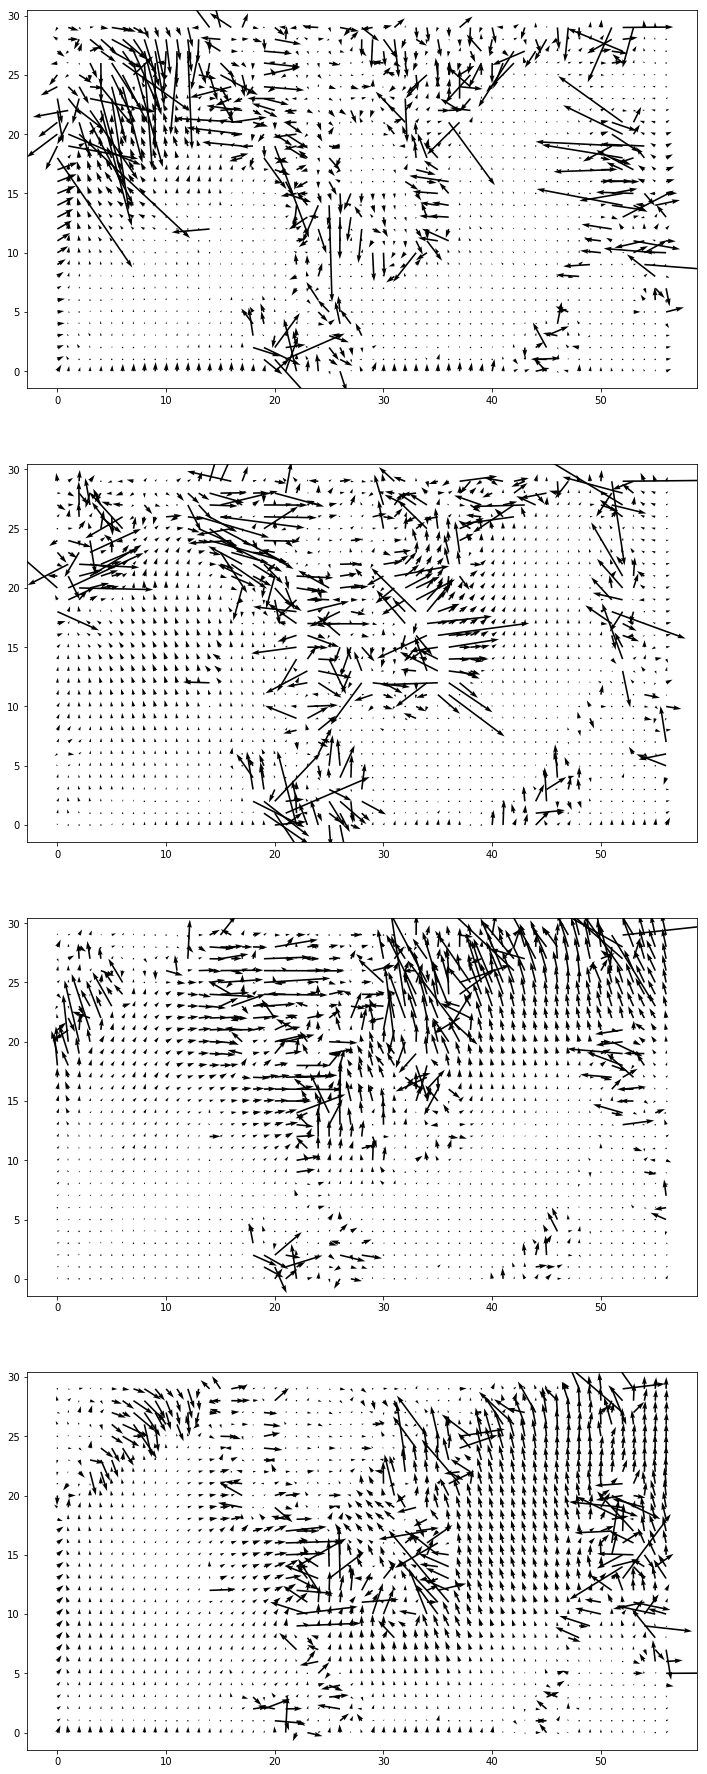

In [299]:
def center_vector(vector,axis):
#     print('original shape',np.shape(vector))
    if(axis==1):
#         print('axis1')
        return np.add(vector[:,1:,:],vector[:,:-1,:])/2
    if(axis==2):
#         print('axis2')
        return np.add(vector[:,:,1:],vector[:,:,:-1])/2

def vapor_flux(filelist_q,filelist_u,filelist_v):
    epoch_seasons_fluxuc=[]
    epoch_seasons_fluxvc=[]
    for kk,filename in enumerate(filelist_q):
        print(filename)
        resolution=27*1000 #meters
        monsoons_q=monsoon(xr.open_dataset(filename,autoclose=True),ppt=False)
        monsoons_v=monsoon(xr.open_dataset(filelist_v[kk],autoclose=True),ppt=False)
        monsoons_u=monsoon(xr.open_dataset(filelist_u[kk],autoclose=True),ppt=False)
        seasons_fluxuc=[]
        seasons_fluxvc=[]
        for ii,monsoon_q in enumerate(monsoons_q):
            vapor_v=np.diff(monsoon_q.QVAPOR.data[:,0,:,:]/monsoon_q.ALT.data[:,0,:,:]/resolution,axis=1)
            vapor_u=np.diff(monsoon_q.QVAPOR.data[:,0,:,:]/monsoon_q.ALT.data[:,0,:,:]/resolution,axis=2)
            fluxv=vapor_v*monsoons_v[ii].V[:,0,1:-1,:]
            fluxu=vapor_u*monsoons_u[ii].U[:,0,:,1:-1]
            fluxuc=center_vector(fluxu,1)
            fluxvc=center_vector(fluxv,2)
            print('1 ',np.shape(fluxuc),type(fluxuc))
#             if(ii==0):
#                 seasons_fluxuc=fluxuc
#                 seasons_fluxvc=fluxvc
#                 print('first seasons_fluxuc',np.shape(seasons_fluxuc))
#             else:
#                 np.append(seasons_fluxuc,fluxuc,axis=0)
#                 np.append(seasons_fluxvc,fluxvc,axis=0)
#                 print('seasons_fluxuc',np.shape(seasons_fluxuc))
            seasons_fluxuc.append(np.mean(fluxuc,axis=0))
            seasons_fluxvc.append(np.mean(fluxvc,axis=0))
            print('2 ',np.shape(seasons_fluxuc),type(seasons_fluxuc))
        epoch_seasons_fluxuc.append(np.array(seasons_fluxuc))
        epoch_seasons_fluxvc.append(np.array(seasons_fluxvc))
        print('3 ',np.shape(epoch_seasons_fluxuc),type(epoch_seasons_fluxuc))
    mean_flux_u=np.mean(np.array(epoch_seasons_fluxuc),axis=0)
    mean_flux_v=np.mean(np.array(epoch_seasons_fluxvc),axis=0)
    print('mean_flux_u',np.shape(mean_flux_u))
    for ii in range(0,4):
        plt.subplot(4,1,ii+1)
        plt.quiver(mean_flux_u[ii][::3,::3],mean_flux_v[ii][::3,::3])
        

# vapor_v=np.diff(c1_01.QVAPOR.data[:,0,:,:],axis=1)
# vapor_u=np.diff(c1_01.QVAPOR.data[:,0,:,:],axis=2)
# fluxv=vapor_v*vwind.V[:,0,1:-1,:]
# fluxu=vapor_u*uwind.U[:,0,:,1:-1]
# print(np.shape(vapor_v),np.shape(vapor_u),np.shape(fluxu),np.shape(fluxv))
# fluxuc=center_vector(fluxu,1)
# fluxvc=center_vector(fluxv,2)
# print(np.shape(fluxuc),np.shape(fluxvc))

# plt.rcParams["figure.figsize"] = 6,4
# plt.pcolormesh(np.mean(fluxv,axis=0),cmap='PRGn',vmin=-0.006,vmax=0.006)
# plt.colorbar()
# plt.figure(2)
# plt.pcolormesh(np.mean(fluxu,axis=0),cmap='PRGn',vmin=-0.006,vmax=0.006)
# plt.colorbar()
plt.rcParams["figure.figsize"] = 12,32
plt.figure(1)
vapor_flux(cloudlist_s1,ulist_s1,vlist_s1)
plt.show()

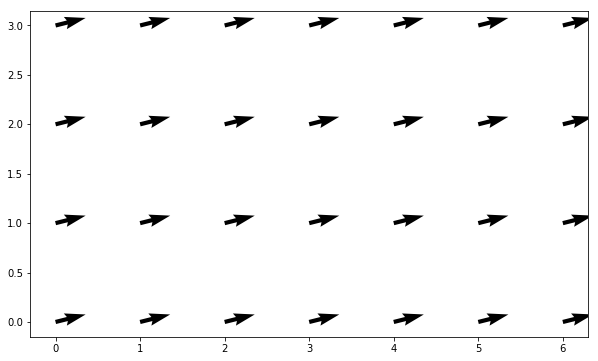

In [298]:
aaa=np.ones([4,7])*4
bbb=np.ones([4,7])*1
plt.quiver(aaa,bbb)
plt.show()

In [213]:
aaa=np.array([1,2,3])
bbb=np.array([[1,2,3],[4,5,6]])

print(np.diff(aaa))
print(bbb)
print(np.diff(bbb,axis=0))

[1 1]
[[1 2 3]
 [4 5 6]]
[[3 3 3]]


In [235]:
aaa=np.array([[1,2,3,5,7,9],[1,2,3,6,7,8]])
print(aaa[:,1:]+aaa[:,:-1])

[[ 3  5  8 12 16]
 [ 3  5  9 13 15]]


# Graveyard

In [ ]:
#data overview
# print('year, s2000, eas0c, diff, %')
# # print('50-54: {:.4f} {:.4f} {:.2f}%'.format(np.mean(s1a.PPT.data),np.mean(s2a.PPT.data),\
# #                                            (np.mean(s2a.PPT.data)-np.mean(s1a.PPT.data))/np.mean(s1a.PPT.data)*100))
# # print('69-73: {:.4f} {:.4f} {:.2f}%'.format(np.mean(s1b.PPT.data),np.mean(s2b.PPT.data),\
# #                                            (np.mean(s2b.PPT.data)-np.mean(s1b.PPT.data))/np.mean(s1b.PPT.data)*100))
# # print('90-94: {:.4f} {:.4f} {:.2f}%'.format(np.mean(s1c.PPT.data),np.mean(s2c.PPT.data),\
# #                                            (np.mean(s2c.PPT.data)-np.mean(s1c.PPT.data))/np.mean(s1c.PPT.data)*100))
# print('mean: {:.4f} {:.4f} {:.4f} {:.2f}%'.format(np.mean(s1.data),np.mean(s2.data),np.mean(s1.data)-np.mean(s2.data),(np.mean(s1.data)-np.mean(s2.data))/np.mean(s1.data)*100))
landmsk=s1_d01.LANDMASK.data
landmsk[landmsk == 0] = np.nan
seamsk=1-s1_d01.LANDMASK.data
seamsk[np.isnan(seamsk)]=1
seamsk[seamsk == 0] = np.nan
print(landmsk[0,:,:])
print(seamsk[0,:,:])
# print('mean over land {:.4f} {:.4f} {:.2f}%'.format(np.nanmean(s1*landmsk[:12,:,:].data),np.nanmean(s2*landmsk[:12,:,:].data),\
#                                                        (np.nanmean(s1*landmsk[:12,:,:].data)-np.nanmean(s2*landmsk[:12,:,:].data))/np.nanmean(s1*landmsk[:12,:,:].data)*100))

#### data from individual runs
year, s2000, eas0c, diff %  
50-54: 9.4236 10.3650 9.99%  
69-73: 9.3686 10.7211 14.44%  
90-94: 9.5697 10.3455 8.11%  
mean: 9.4059 10.4337 10.93%  
mean over land 7.1474 7.7201 8.01%
##### Last 3 years
mean: 10.1881 11.1170 9.12%  
mean over land 7.7872 8.3445 7.16%


In [ ]:
landmsk=s1raw.LANDMASK.data
plt.rcParams["figure.figsize"] = 8,8
base=s1.data
base[base == 0]=np.nan
diffabs=[]
diffratio=[]
for tt in range(0,12):
    plt.figure(tt)
    uwind1=np.mean(s1_u10[:,::10,::10],axis=0)
    vwind1=np.mean(s1_v10[:,::10,::10],axis=0)
    slon1 = s1raw.lon[0::10]
    slat1 = s1raw.lat[0::10]
    uwind2=np.mean(s2_u10[:,::10,::10],axis=0)
    vwind2=np.mean(s2_v10[:,::10,::10],axis=0)
    slon2 = s2raw.lon[0::10]
    slat2 = s2raw.lat[0::10]
    ax1=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
    ax1.pcolor(s1raw.lon, s1raw.lat,s1[tt,:,:],vmin=0,vmax=40,cmap='Blues')
    ax1.quiver(slon1,slat1,uwind1,vwind1,pivot='middle')
    ax1.coastlines()
    ax2=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
    ax2.pcolor(s1raw.lon,s1raw.lat,s2[tt,:,:],vmin=0,vmax=40,cmap='Blues')
    ax2.quiver(slon2,slat2,uwind2,vwind2,pivot='middle')
    ax2.coastlines()
    cmap = plt.get_cmap('Blues')
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=matplotlib.colors.Normalize(vmin=0, vmax=40))
    sm._A = []
    plt.colorbar(sm,ax=ax2,fraction=0.04, pad=0.05)
    plt.colorbar(sm,ax=ax1,fraction=0.04, pad=0.05)
    ax3=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
    ax3.pcolor(s1raw.lon,s1raw.lat,s1[tt,:,:]-s2[tt,:,:],vmax=10,vmin=-10,cmap='RdBu')
    ax3.coastlines()
    cmap = plt.get_cmap('RdBu')
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=matplotlib.colors.Normalize(vmin=-10, vmax=10))
    sm._A = []
    plt.colorbar(sm,ax=ax3,fraction=0.04, pad=0.05)
    ax4=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
    ratiomap=(s1[tt,:,:]-s2[tt,:,:])/(base[tt,:,:])
#     m = np.ma.masked_where(np.isnan(ratiomap),ratiomap)
#     m=np.ma.masked_invalid(ratiomap)
    cmap = plt.get_cmap('RdBu')
    cmap.set_bad('k')
    ax4.pcolor(s1raw.lon,s1raw.lat,ratiomap,vmax=2,vmin=-2,cmap=cmap)
    ax4.coastlines()
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=matplotlib.colors.Normalize(vmin=-2., vmax=2.))
    sm._A = []
    plt.colorbar(sm,ax=ax4,fraction=0.04, pad=0.05)
    diffabs.append(np.nanmean(s1[tt,:,:]*landmsk[0,:,:]-s2[tt,:,:]*landmsk[0,:,:]))
    diffratio.append((np.nanmean(s1[tt,:,:]*landmsk[0,:,:])-np.nanmean(s2[tt,:,:]*landmsk[0,:,:]))/np.nanmean(s1[tt,:,:]*landmsk[0,:,:])*100)
    
    print('Month is {} Mean diff over land: {:.4f}, {:.2f}%'.format(tt+1,np.nanmean(s1[tt,:,:]*landmsk[0,:,:]-s2[tt,:,:]*landmsk[0,:,:]),\
                                                          (np.nanmean(s1[tt,:,:]*landmsk[0,:,:])-np.nanmean(s2[tt,:,:]*landmsk[0,:,:]))/np.nanmean(s1[tt,:,:]*landmsk[0,:,:])*100))
    plt.show()

## Comparisons for qcloud

In [ ]:
c1_01=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_2000_01_d01_TPCV.nc')
c2_01=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/wrfpost_run_eas0c_01_d01_TPCV.nc')

In [ ]:
dif = c1_01.z[0,1:,10,10].data
plt.plot(dif)
plt.show()
print(c1_01.z)
print(c1_01.z[0,1:,10,10])
print(c1_01.z[0,:-1,10,10])
np.sum(c1_01.z[0,1:,10,10].data)

In [ ]:
plt.rcParams["figure.figsize"] = 14,6
print(c1)
# plt.plot(c1.z[80,:,80,80])

inter=[]
inter2=[]
for i in range(1,29):
    inter.append(c1.z[80,i,80,80]-c1.z[80,i-1,80,80])
for i in range(1,29):
    inter2.append(c2.z[80,i,80,80]-c2.z[80,i-1,80,80])
plt.plot(inter)
plt.plot(inter2)

print(len(inter))
print(np.shape(c1.z))
plt.show()

In [ ]:
#calculate cloud mass per m^2 this assumes z is not cumulative
s1cloud=c1.QCLOUD/c1.ALT*c1.z
s2cloud=c2.QCLOUD/c2.ALT*c1.z

In [ ]:
s1cloudcut=s1cloud.sel(time=slice('2052-01-01', '2055-01-01'))
s2cloudcut=s2cloud.sel(time=slice('2052-01-01', '2055-01-01'))
print(np.shape(s1cloud))
s1cloudmtha=s1cloudcut.resample('1M',dim='time',how='mean')
s2cloudmtha=s2cloudcut.resample('1M',dim='time',how='mean')
print(np.shape(s2cloudmtha))
s1cloudmth=s1cloudmtha.groupby('time.month').mean(axis=0)
s2cloudmth=s2cloudmtha.groupby('time.month').mean(axis=0)
# s1cloudmth.to_netcdf('/home/likkhian/dhobyghaut/cesm_output_convert/analysis/downscale_results/qcloud_mth_s2000.nc')
# s2cloudmth.to_netcdf('/home/likkhian/dhobyghaut/cesm_output_convert/analysis/downscale_results/qcloud_mth_eas0c.nc')
# s1cloudmth=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/qcloud_mth_s2000.nc')
# s2cloudmth=xr.open_dataset('../cesm_output_convert/analysis/downscale_results/qcloud_mth_eas0c.nc')
print(np.shape(s1cloudmth))
# print(np.shape(s1cloudmth.__xarray_dataarray_variable__))

In [ ]:
plt.figure(1)
plt.plot(np.mean(s1cloudmtha,axis=(1,2,3)),label='s2000')
plt.plot(np.mean(s2cloudmtha,axis=(1,2,3)),label='eas0c')
plt.legend()

plt.figure(2)
plt.plot(np.mean(s1cloudmth,axis=(1,2,3)),label='s2000')
plt.plot(np.mean(s2cloudmth,axis=(1,2,3)),label='eas0c')
plt.legend()

plt.show()

In [ ]:
print('month, s2000, eas0c, eas0c-2000, (eas0c-2000)/2000')
for tt in range(0,12):
    a=np.sum(s1cloudmth[tt,:,:,:].data)#.__xarray_dataarray_variable__[tt,:,:,:].data)
    b=np.sum(s2cloudmth[tt,:,:,:].data)#.__xarray_dataarray_variable__[tt,:,:,:].data)
    print('{}, {:.4f}, {:.4f}, {:.4f}, {:.4f}%'.format(tt+1,a,b,b-a,(b-a)/a*100))
print('All, {:.4f}, {:.4f}, {:.4f}, {:.4f}%'.format(np.sum(s1cloudmth.data),np.sum(s2cloudmth.data),np.sum(s2cloudmth.data)-np.sum(s1cloudmth.data),(np.sum(s2cloudmth.data)-np.sum(s1cloudmth.data))/np.sum(s1cloudmth.data)*100))

### from 3 yrs of data
month, s2000, eas0c, eas0c-2000, (eas0c-2000)/2000 <br>
1, 10263.8396, 10092.1120, -171.7276, -1.6731% <br>
2, 6932.8946, 6342.5810, -590.3136, -8.5147% <br>
3, 4385.7905, 4756.0239, 370.2333, 8.4417% <br>
4, 4025.7188, 4856.2369, 830.5181, 20.6303% <br>
5, 6148.2023, 5724.0534, -424.1489, -6.8987% <br>
6, 6553.1076, 7430.5333, 877.4257, 13.3895% <br>
7, 9375.8804, 10765.6644, 1389.7840, 14.8230% <br>
8, 11165.5405, 11567.9899, 402.4493, 3.6044% <br>
9, 11606.3236, 12084.6815, 478.3579, 4.1215% <br>
10, 11729.1931, 12436.5651, 707.3719, 6.0309% <br>
11, 11178.4660, 11215.9444, 37.4784, 0.3353% <br>
12, 11662.5519, 11017.3541, -645.1979, -5.5322% <br>

### from 5 yrs of data
month, s2000, eas0c, eas0c-2000, (eas0c-2000)/2000 <br>
1, 8182.4760, 8530.1588, 347.6828, 4.2491% <br>
2, 5534.7462, 5541.9107, 7.1645, 0.1294% <br>
3, 3665.7372, 4348.2797, 682.5424, 18.6195% <br>
4, 3277.8825, 3845.5130, 567.6306, 17.3170% <br>
5, 5098.9709, 5393.8096, 294.8387, 5.7823% <br>
6, 5655.6789, 6867.5313, 1211.8524, 21.4272% <br>
7, 8304.8219, 9240.5539, 935.7320, 11.2673% <br>
8, 10357.6125, 11007.8795, 650.2670, 6.2782% <br>
9, 10222.5415, 11112.8884, 890.3469, 8.7096% <br>
10, 10379.1819, 10770.6256, 391.4436, 3.7714% <br>
11, 9573.8657, 9452.8191, -121.0466, -1.2643% <br>
12, 10753.0003, 9574.5381, -1178.4621, -10.9594% <br>

### from the old QCLOUD/ALT method.
month, s2000, eas0c, eas0c-2000, (eas0c-2000)/2000 <br>
1, 2.9401, 4.0482, 1.1081, 37.6895% <br>
2, 2.0836, 2.7201, 0.6366, 30.5525%<br>
3, 1.5781, 2.7416, 1.1635, 73.7331%<br>
4, 0.7897, 1.2373, 0.4477, 56.6905%<br>
5, 0.7766, 1.4627, 0.6861, 88.3409%<br>
6, 1.5147, 2.2099, 0.6952, 45.8989%<br>
7, 3.3710, 2.8347, -0.5363, -15.9086%<br>
8, 4.9462, 4.5077, -0.4384, -8.8644%<br>
9, 4.2341, 4.1415, -0.0927, -2.1885%<br>
10, 3.0768, 2.2144, -0.8624, -28.0300%<br>
11, 2.7405, 2.1833, -0.5573, -20.3337%<br>
12, 3.7496, 3.2070, -0.5426, -14.4705%<br>

In [ ]:
landmask=s1a.LANDMASK[0,:,:]
print('month, s2000, eas0c, eas0c-2000, (eas0c-2000)/2000')
for tt in range(0,12):
    a=np.sum(np.sum(s1cloudmth.__xarray_dataarray_variable__[tt,:,:,:].data,axis=0)*landmask.data)
    b=np.sum(np.sum(s2cloudmth.__xarray_dataarray_variable__[tt,:,:,:].data,axis=0)*landmask.data)
#     print((tt+1,a,b,b-a,(b-a)/a))
    print('{}, {:.4f}, {:.4f}, {:.4f}, {:.4f}%'.format(tt+1,a,b,b-a,(b-a)/a*100))

In [ ]:
'''
OLD QUARTERLY PDF PLOTS
'''

# def plt_qtr_pdf(ii):
#     fig, ax = plt.subplots(2,2,sharex=True)#,sharey=True)
#     ax[0,0].set_title('Precipitation PDF CESM d01')
#     x=qtr_reshape(s1_cesm_all.PPT.data)[:,ii,:,:].flatten()
#     plot_pdf(x,'s2000',ax[0,0],'b')
#     x2=qtr_reshape(s2_cesm_all.PPT.data)[:,ii,:,:].flatten()
#     plot_pdf(x2,'eas0c',ax[0,0],'r')
#     x3=qtr_reshape(s1_cesm_all.PPT.data*landmask_cesm)[:,ii,:,:].flatten()
#     x3= x3[~np.isnan(x3)]
#     plot_pdf(x3,'s2000 land',ax[0,0],'b--')
#     x4=qtr_reshape(s2_cesm_all.PPT.data*landmask_cesm)[:,ii,:,:].flatten()
#     x4= x4[~np.isnan(x4)]
#     plot_pdf(x4,'eas0c land',ax[0,0],'r--')
#     x5=qtr_reshape(s1_cesm_all.PPT.data*seamask_cesm)[:,ii,:,:].flatten()
#     x5= x5[~np.isnan(x5)]
#     plot_pdf(x5,'s2000 sea',ax[0,0],'b:')
#     x6=qtr_reshape(s2_cesm_all.PPT.data*seamask_cesm)[:,ii,:,:].flatten()
#     x6= x6[~np.isnan(x6)]
#     plot_pdf(x6,'eas0c sea',ax[0,0],'r:')
#     plt.xlim( (0, 50) )
#     ax[0,0].text(-0.1, 1.05, 'a', transform=ax[0,0].transAxes, 
#                 size=10, weight='bold')

#     ax[1,0].set_title('Precipitation PDF 27km d01')
#     x=qtr_reshape(s1_d01_mth.PPT.data)[:,ii,:,:].flatten()
#     plot_pdf(x,'s2000',ax[1,0],'b')
#     x2=qtr_reshape(s2_d01_mth.PPT.data)[:,ii,:,:].flatten()
#     plot_pdf(x2,'eas0c',ax[1,0],'r')
#     x3=qtr_reshape(s1_d01_mth.PPT.data*landmask_d01)[:,ii,:,:].flatten()
#     x3= x3[~np.isnan(x3)]
#     plot_pdf(x3,'s2000 land',ax[1,0],'b--')
#     x4=qtr_reshape(s2_d01_mth.PPT.data*landmask_d01)[:,ii,:,:].flatten()
#     x4= x4[~np.isnan(x4)]
#     plot_pdf(x4,'eas0c land',ax[1,0],'r--')
#     x5=qtr_reshape(s1_d01_mth.PPT.data*seamask_d01)[:,ii,:,:].flatten()
#     x5= x5[~np.isnan(x5)]
#     plot_pdf(x5,'s2000 sea',ax[1,0],'b:')
#     x6=qtr_reshape(s2_d01_mth.PPT.data*seamask_d01)[:,ii,:,:].flatten()
#     x6= x6[~np.isnan(x6)]
#     plot_pdf(x6,'eas0c sea',ax[1,0],'r:')
#     ax[1,0].text(-0.1, 1.05, 'b', transform=ax[1,0].transAxes, 
#                 size=10, weight='bold')

#     ax[0,1].set_title('Precipitation PDF 27km d02')
#     # x=np.mean(s1_d012.PPT,axis=(1,2))
#     x=qtr_reshape(s1_d012_mth.PPT.data)[:,ii,:,:].flatten()
#     plot_pdf(x,'s2000',ax[0,1],'b')
#     # x2=np.mean(s2_d012_mth.PPT,axis=(1,2))
#     x2=qtr_reshape(s2_d012_mth.PPT.data)[:,ii,:,:].flatten()
#     plot_pdf(x2,'eas0c',ax[0,1],'r')
#     x3=qtr_reshape(s1_d012_mth.PPT.data*landmask_d012)[:,ii,:,:].flatten()
#     x3= x3[~np.isnan(x3)]
#     plot_pdf(x3,'s2000 land',ax[0,1],'b--')
#     x4=qtr_reshape(s2_d012_mth.PPT.data*landmask_d012)[:,ii,:,:].flatten()
#     x4= x4[~np.isnan(x4)]
#     plot_pdf(x4,'eas0c land',ax[0,1],'r--')
#     x5=qtr_reshape(s1_d012_mth.PPT.data*seamask_d012)[:,ii,:,:].flatten()
#     x5= x5[~np.isnan(x5)]
#     plot_pdf(x5,'s2000 sea',ax[0,1],'b:')
#     x6=qtr_reshape(s2_d012_mth.PPT.data*seamask_d012)[:,ii,:,:].flatten()
#     x6= x6[~np.isnan(x6)]
#     plot_pdf(x6,'eas0c sea',ax[0,1],'r:')
#     ax[0,1].text(-0.1, 1.05, 'c', transform=ax[0,1].transAxes, 
#                 size=10, weight='bold')

#     ax[1,1].set_title('Precipitation PDF 9km d02')
#     x=qtr_reshape(s1_d02_mth.PPT.data)[:,ii,:,:].flatten()
#     plot_pdf(x,'s2000',ax[1,1],'b')
#     x2=qtr_reshape(s2_d02_mth.PPT.data)[:,ii,:,:].flatten()
#     plot_pdf(x2,'eas0c',ax[1,1],'r')
#     x3=qtr_reshape(s1_d02_mth.PPT.data*landmask_d02)[:,ii,:,:].flatten()
#     x3= x3[~np.isnan(x3)]
#     plot_pdf(x3,'s2000 land',ax[1,1],'b--')
#     x4=qtr_reshape(s2_d02_mth.PPT.data*landmask_d02)[:,ii,:,:].flatten()
#     x4= x4[~np.isnan(x4)]
#     plot_pdf(x4,'eas0c land',ax[1,1],'r--')
#     x5=qtr_reshape(s1_d02_mth.PPT.data*seamask_d02)[:,ii,:,:].flatten()
#     x5= x5[~np.isnan(x5)]
#     plot_pdf(x5,'s2000 sea',ax[1,1],'b:')
#     x6=qtr_reshape(s2_d02_mth.PPT.data*seamask_d02)[:,ii,:,:].flatten()
#     x6= x6[~np.isnan(x6)]
#     plot_pdf(x6,'eas0c sea',ax[1,1],'r:')
#     ax[1,1].text(-0.1, 1.05, 'd', transform=ax[1,1].transAxes, 
#                 size=10, weight='bold')

# for ii in range(1,5):
#     plt.figure(ii)
#     plt_qtr_pdf(ii-1)
#     plt.suptitle(quarters[ii])
#     plt.show()

## Raw output exploration

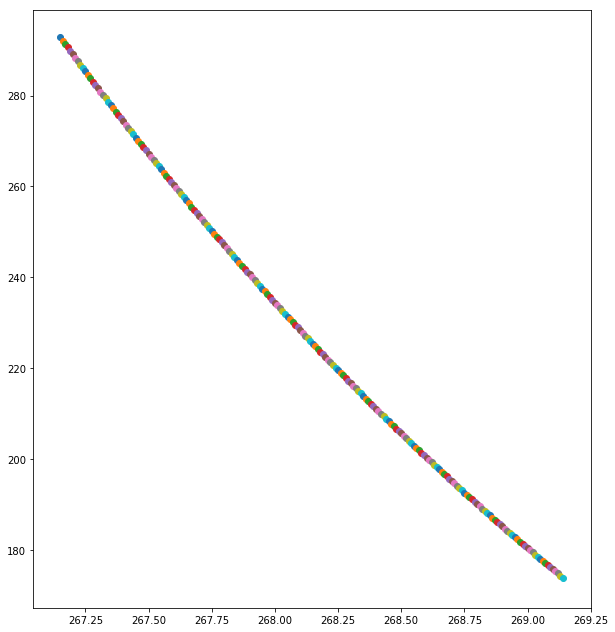

In [131]:
#This is how morrison gettelman calculates number of ice nuclei in clouds below freezing
import math
def nacnt(t):
    return math.exp(-2.8+0.262*(273.15-t))*1000
temps=np.arange(273.15-6,273.15-4,0.01)
for temp in temps:
    plt.scatter(temp,nacnt(temp))
plt.show()